# Teil II zum Praktischen Teil der Bachelorarbeit zum Thema 
## Dynamic Pricing in der Luftfahrt: Analyse von Machine-Learning-Algorithmen zur Vorhersage von Flugpreisen
#### Von Dominik Lewin, Matrikelnummer 3274837

In diesem zweiten Jupyter Notebook wird es darum gehen, die Daten vorzubereiten und für das Training an die verschiedenen ML-Algorithmen zu übergeben. Die Modelle werden optimiert und anschließend getestet. Anschließend wird eine Simulation von Flugbuchungen durchgeführt, um den praktischen Einsatz der ML-Modelle simulieren zu können.

Das gesamte Projekt basiert auf dem Vorgehensmodell CRISP-DM, bei dem nach der Datenaufbereitung zunächst das Modeling und anschließend das Testen erfolgen. Aus Gründen der besseren Übersichtlichkeit werden die Schritte "Trainieren", "Optimieren" und "Testen" in diesem Jupyter Notebook immer zusammenhängend je Algorithmus dargestellt, um insbesondere die Modelle und Variablenbelegungen nachvollziehen zu können. 

Unterschieden wird zudem zwischen dem Regressionsproblem und dem Klassifikationsproblem. Diese werden getrennt voneinander dargestellt, weshalb sich gewisse ML-Algrithmen wiederholen können.


# Inhaltsverzeichnis

* [1. Auswahl der Merkmale](#auswahl-der-merkmale)
* [2. Datenbereinigung](#datenbereinigung)
* [3. Datenaufbereitung](#datenaufbereitung)
* [4. Erstellen des Trainings- und Testdatensatzes](#datensatz)
* [5. Anwendung der ML-Algorithmen (Regressionsproblem)](#anwendung-regressionsproblem)
    * [5.1. Lineare Regression](#lineare-regression)
    * [5.2. Entscheidungsbäume](#entscheidungsbaeume)
    * [5.3. Random Forest](#random-forest)
    * [5.4. k-Nearest Neighbor](#k-nearest-neighbor)
    * [5.5. SVM](#svm)
    * [5.6. MLP](#mlp)
* [6. Anwendung der ML-Algorithmen (Klassifikationsproblem)](#anwendung-klassifikationsproblem)
    * [6.1. Trainieren aller Algorithmen](#trainieren-aller-algorithmen)
    * [6.2. Entscheidungsbäume](#entscheidungsbaeume-2)
    * [6.3. Random Forest](#random-forest-2)
    * [6.4. k-Nearest Neighbor](#neigh)
* [7. Simulation von Flugbuchungen](#simulation)
    * [7.1. Regressionsproblem](#simreg)
    * [7.2. Klassifikationsproblem](#simklas)
* [8. Fazit](#fazit)
    * [8.1. Regressionsproblem](#fazit2)
    * [8.2. Klassifikationsproblem](#fazit3)


## 1. Auswahl der Merkmale <a class="anchor" id="auswahl-der-merkmale"></a>

Die zur Vorhersage am besten geeigneten Merkmale wurden bereits im ersten Notebook herausgearbeitet. Dementsprechend sollen die Merkmale *Zielflughafen*, *Airline* und *Tage bis Abflug* auf jeden Fall verwendet werden, wobei Letzteres noch nicht im Datensatz vorhanden ist und erzeugt werden muss. 

Zudem sollen auch die Attribute *Abflugzeit* und *Wochentag des Abflugs* beibehalten bzw. erzeugt werden. 

Natürlich muss auch der *Preis* als Label beibehalten werden. Weitere sinvolle Attribute, die sich beispielsweise aus dem Verhältnis zweier Attribute bilden lassen könnten, wurden nicht gefunden. Dies liegt insbesondere daran, dass es sich größtenteils um kategorische Attribute handelt. 

Die verbleibenden Attribute werden aus den folgenden Gründen entfernt:

- Buchungsdatum: Das genaue Buchungsdatum ist für eine Vorhersage nicht relevant, da es zu einem Overfitting führen könnte. Außerdem ist der Datensatz zu klein, um anzunehmen, dass dieses Attribut einen Einfluss auf den Preis haben könnte.
- Wochentag der Buchung: Dieses Attribut hat, wie im vorherigen Kapitel erwähnt, keinen nennenswerten Einfluss auf den Preis.
- Abflugdatum: Dieses Attribut ist zu speziell und nicht repräsentativ. Die Anzahl der Tage vor Abflug ist allgemeiner und für ML-Algorithmen besser geeignet.
- Abflughafen: Da es sich immer um den Flughafen Hamburg handelt, kann dieses Attribut entfallen.
- Ankunftszeit: Die Ankunftszeit hat die selbe Aussagekraft wie die Abflugzeit, weshalb ein Attribut ausreichend ist. Die Ankunftszeit ist lediglich die um die Flugzeit aufaddierte Abflugzeit.

## 2. Datenbereinigung <a class="anchor" id="datenbereinigung"></a>

Fehlende Werte sollten bereinigt werden, damit ML-Algorithmen mit den Daten arbeiten können. Hierfür gibt es mehrere Möglichkeiten. Diese sind u.a.:

- Die entsprechenden Datenpunkte (Zeilen) mit fehlenden Werten werden ersatzlos entfernt.
- Das Merkmal wird ersatzlos entfernt (auch für Datenpunkte, die eigentlich einen Wert dieses Attributs besitzen).
- Fehlende Werte werden ersetzt (z.B. durch arithmetisches Mittel, Median, null, etc.).

Wie zuvor gezeigt, sind lediglich im Attribut *Preis* fehlende Werte vorhanden, weshalb die betreffenden Datenpunkte entfernt werden sollen. Der Umgang mit diesen Werten wurde bereits ausführlich diskutiert. 

Im Folgenden wird zunächst der Datensatz eingelesen und anschließend die weiteren Attribute hinzugefügt. Das Attribut *Abflugzeit* wird bereits in ein kategorische Attribut umgewandelt (wie es bereits im ersten Jupyter Notebook gezeigt wurde).

In [3]:
#Erste Pakete importieren, die im gesamten Notebook mehrfach benötigt werden
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from datetime import time
from datetime import datetime
pd.options.mode.chained_assignment = None
import category_encoders as ce
import math

In [4]:
#Einlesen des Datensatzes. Die beiden Kalenderdaten werden direkt im richtigen Format eingelesen
data = pd.read_csv("flight_price_data.csv", 
                sep=";", 
                parse_dates=["Buchungsdatum", "Abflugdatum"])

#Funktion, um die Zeiten von Strings in datetime.time-Objekte umzuwandeln
def konvertiere(zeit_string):
    zeit = datetime.strptime(zeit_string, "%H:%M:%S").time()
    return zeit

#Wende die Funktion auf die Abflugzeit und Ankunftszeit an
data["Abflugzeit"] = data["Abflugzeit"].apply(konvertiere)
data["Ankunftszeit"] = data["Ankunftszeit"].apply(konvertiere)

#Es wird zunächst eine Kopie des Datensatzes erzeugt, um den originalen Datensatz nicht zu verändern
df = data.copy()

#Hinzufügen der weiteren Attribute
#Wochentage hinzufügen (zunächst als Ganzzahl, anschließend Konvertierung in richtigen Wochentag -> nominal)
wochentage_mapping={
    0: "Montag",
    1: "Dienstag",
    2: "Mittwoch",
    3: "Donnerstag",
    4: "Freitag",
    5: "Samstag",
    6: "Sonntag"
}
df["Wochentag des Abflugs"] = df["Abflugdatum"].dt.dayofweek
df["Wochentag des Abflugs"] = df["Wochentag des Abflugs"].map(wochentage_mapping)

#Tage bis Abflug hinzufügen
df["Tage bis Abflug"] = df["Abflugdatum"]-df["Buchungsdatum"]
df["Tage bis Abflug"] = pd.to_timedelta(df["Tage bis Abflug"]).dt.days

#Abflugzeit in Kategorien konvertieren (wie in vorherigem Notebook)
#Funktion definieren
def konvertiere_abflugzeit(abflugzeit):
    
    if(abflugzeit < time(8,0,0)):
        return "frueh_morgens"
    elif(abflugzeit < time(11,0,0)):
        return "morgens"
    elif(abflugzeit < time(14,0,0)):
        return "mittags"
    elif(abflugzeit < time(18,0,0)):
        return "nachmittags"
    elif(abflugzeit <= time(23,59,59)):
        return "abends"
    else:
        #Fehlercode, sollte aber nicht vorkommen
        return "Fehler"

#Wende die Funktion auf die Abflugzeit an -> Attribut wird überschrieben!
df["Abflugzeit"] = df["Abflugzeit"].apply(konvertiere_abflugzeit)
df.head()

,Buchungsdatum,Abflugdatum,Abflughafen,Zielflughafen,Abflugzeit,Ankunftszeit,Preis,Flugnummer,Airline,Wochentag des Abflugs,Tage bis Abflug
0,2022-11-09,2023-02-26,HAM,LHR,nachmittags,18:40:00,98.0,EW 7460,Eurowings,Sonntag,109
1,2022-11-10,2023-02-26,HAM,LHR,nachmittags,18:40:00,98.0,EW 7460,Eurowings,Sonntag,108
2,2022-11-11,2023-02-26,HAM,LHR,nachmittags,18:40:00,98.0,EW 7460,Eurowings,Sonntag,107
3,2022-11-12,2023-02-26,HAM,LHR,nachmittags,18:40:00,98.0,EW 7460,Eurowings,Sonntag,106
4,2022-11-13,2023-02-26,HAM,LHR,nachmittags,18:40:00,98.0,EW 7460,Eurowings,Sonntag,105


Als nächstes werden die Datenpunkte, die NaN-Werte enthalten, entfernt. Auch die nicht benötigten Attribute werden komplett entfernt, wobei das Attribut *Abflugdatum* zunächst bestehen bleibt und in einem späteren Schritt entfernt wird, da dieses Attribut noch für weitere Berechnungen benötigt wird.

In [5]:
#Es werden alle NaN-Werte entfernt und der Preis als int-Wert gespeichert
df = df.dropna()
df["Preis"] = df["Preis"].astype(int)

#Spalten entfernen
df = df.drop(["Buchungsdatum", "Abflughafen", "Ankunftszeit"], axis=1)

#Sortierung der Attribute in anderer Reihenfolge
df = pd.DataFrame.reindex(df,columns = ["Flugnummer","Abflugdatum", "Airline", "Zielflughafen", 
                                        "Wochentag des Abflugs", "Abflugzeit", "Tage bis Abflug", "Preis"])
df

,Flugnummer,Abflugdatum,Airline,Zielflughafen,Wochentag des Abflugs,Abflugzeit,Tage bis Abflug,Preis
0,EW 7460,2023-02-26,Eurowings,LHR,Sonntag,nachmittags,109,98
1,EW 7460,2023-02-26,Eurowings,LHR,Sonntag,nachmittags,108,98
2,EW 7460,2023-02-26,Eurowings,LHR,Sonntag,nachmittags,107,98
3,EW 7460,2023-02-26,Eurowings,LHR,Sonntag,nachmittags,106,98
4,EW 7460,2023-02-26,Eurowings,LHR,Sonntag,nachmittags,105,98
...,...,...,...,...,...,...,...,...
47226,BA 975,2023-03-25,British Airways,LHR,Samstag,nachmittags,3,550
47227,BA 975,2023-03-25,British Airways,LHR,Samstag,nachmittags,2,550
47228,EW 7464,2023-03-25,Eurowings,LHR,Samstag,frueh_morgens,1,370
47229,BA 975,2023-03-25,British Airways,LHR,Samstag,nachmittags,1,340


Nachdem alle NaN-Werte entfernt wurden, sollen nun Ausreißer gefunden und bearbeitet werden, da es sich hierbei um besonders hohe Preise handelt, die in der Regel nicht auftreten und daher nich repräsentativ sind. Es kann ausgeschlossen werden, dass es sich hierbei um einen fehlerhaften Wert handelt, da die Daten selbst beschafft worden und demnach korrekt sind. Die Werte werden zudem nicht mit dem Median ersetzt, da dies die Daten verfälschen würde und einen deutlich niedrigeren Preis zu diesem Zeitpunkt vortäuschen würde. Eine komplette Entfernung dieser Werte ist ebenfalls sinnlos, da die Preise wenige Tage vor Abflug deutlich ansteigen und eine Entfernung dieses Verhalten nicht widerspiegeln würde. 

Aus diesem Grund sollen die Ausreißer abgeschwächt werden, um den Durchschnitt nicht in die Höhe zu treiben. Für Ausreißer wird daher das Maximum der verbleibenden Werte verwendet und der alte Wert ersetzt.

Die Ausreißer werden je Airline betrachtet. Hierfür werden zwei Plots je Airline erzeugt. Während der obere Plot die Preise auf der x-Achse darstellt, werden auf der y-Achse die Häufigkeiten der jeweiligen Preise abgetragen. Unten wird anschließend ein Boxplot dargestellt, der lediglich die Preise auf der x-Achse darstellt. Ersichtlich werden hier vor allem das untere Quartil, der Median, das obere Quartil und das Minimum und Maximum. Zudem werden in den Kreisen die gesuchten Ausreißer dargestellt.

In [6]:
#Funktion definieren, um die Ausreißer je Airline zu plotten
#Eingabedaten: Gesamter Datensatz und Name der Airline
def plot_ausreisser(data, airline): 
    
    #Datensatz sortieren, sodass nur Preise der jeweiligen Airline vorhanden sind 
    #(absteigend sortiert nach Preis)
    data_airline = data[data["Airline"] == airline]["Preis"].value_counts().reset_index()
    data_airline.rename(columns= {"index":"Preis", "Preis":"Häufigkeit"}, inplace=True)
    data_airline = data_airline.sort_values("Preis", ascending=False)
    print(airline)
    print()
    print(data_airline.head(11))    #Gebe die 11 teuersten Preise aus (bester Erfahrungswert nach Ausprobieren)
    
    #x- und y-Werte bestimmen
    x_werte = data_airline["Preis"]
    y_werte = data_airline["Häufigkeit"]
    
    #plotten
    fig, axes = plt.subplots (2,1, figsize=(10,6)) 
    axes[0].bar(x_werte, y_werte, width=1.5)
    axes[1].boxplot(x_werte, vert=False)
    
    axes[1].set_xlabel("Preis in Euro", size=10)
    axes[0].set_ylabel("Häufigkeit", size=10)  

British Airways

    Preis  Häufigkeit
73    927          11
46    653          47
39    550          67
43    538          56
57    526          28
76    514          10
66    501          21
59    490          27
45    478          51
33    466          93
80    454           7


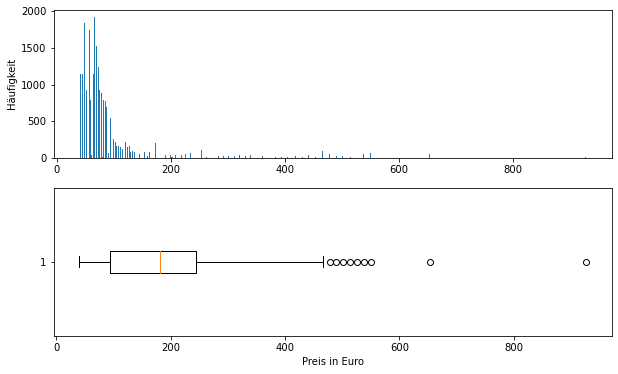

In [7]:
#Plotte Ausreißer für British Airways
plot_ausreisser(df, "British Airways")

Es ist ersichtlich, dass British Airways 9 Preise hat, die als Ausreißer eingestuft werden können. Alle Ausreißer werden mit dem Maximum belegt, das entsteht, wenn die Ausreißer entfernt würden. In diesem Fall also mit 466 Euro. Die Datenpunkte, die zuvor als Ausreißer erkannt wurden, sind nun weiterhin vorhanden und immer noch als höchster Preis gekennzeichnet, dieser wurde aber abgeschwächt. Auf diese Weise wurden die Ausreißer eliminiert.

In [8]:
#Funktion, um Ausreißer im Datensatz zu ersetzen, übergeben wird der Datensatz,
#die Airline und das Maximum, das entsteht, wenn die Ausreißer entfernt werden würden.
#Zurückgegeben wird der bereinigte Datensatz, in dem Ausreißer der jeweiligen Airline behandelt wurden

def ersetze(data, airline, preis):
    data = data.copy()
    bedingung = (data["Airline"] == airline) & (data["Preis"] > preis)
    data.loc[bedingung, "Preis"] = preis
    return data

In [9]:
#Ersetze die Ausreißer von British Airways
df_bereinigt = ersetze(df, "British Airways", 466)

Eurowings

    Preis  Häufigkeit
68    420           1
54    370           4
56    369           3
61    320           2
40    319          16
44    270          10
31    269          33
74    241           1
62    236           2
42    230          14
32    229          32


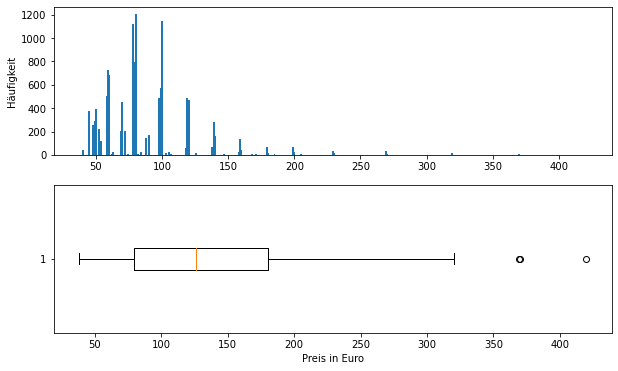

In [10]:
#Plotte Ausreißer für Eurowings
plot_ausreisser(df, "Eurowings")

In [11]:
#Ersetze Ausreißer von Eurowings
df_bereinigt = ersetze(df_bereinigt, "Eurowings", 320)

easyJet

    Preis  Häufigkeit
72    174           4
71    169           5
90    166           2
81    165           2
59    163          10
99    162           1
77    158           3
83    157           2
82    156           2
76    155           3
60    151           9


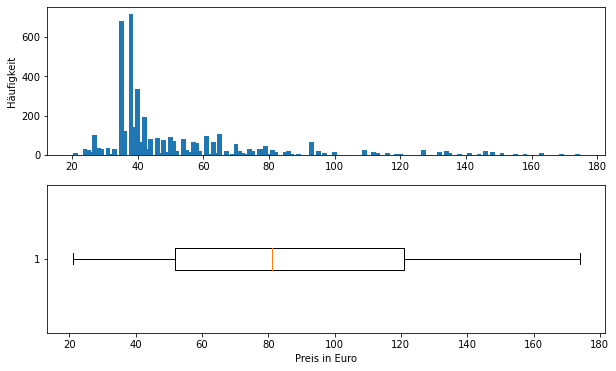

In [12]:
#Plotte Ausreißer für easyJet
plot_ausreisser(df, "easyJet")

Bei easyJet sind keine Ausreißer vorhanden, die ersetzt werden müssen.

Ryanair

     Preis  Häufigkeit
106    439           1
107    428           1
108    405           1
68     396           4
78     385           3
27     375          21
123    353           1
112    332           1
99     325           2
30     318          17
116    289           1


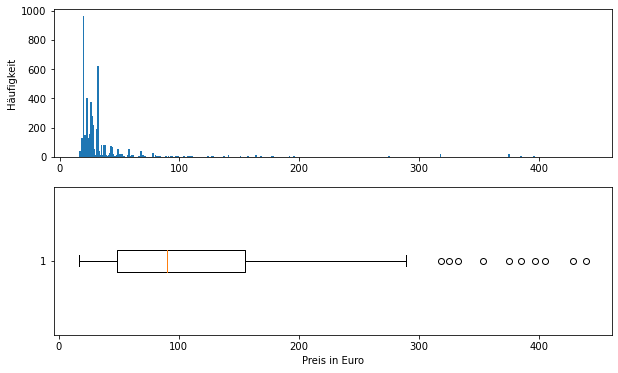

In [13]:
#Plotte Ausreißer für Ryanair
plot_ausreisser(df, "Ryanair")

In [14]:
#Ersetze Ausreißer von Ryanair
df_bereinigt = ersetze(df_bereinigt, "Ryanair", 289)

In [15]:
#Der bereinigte Datensatz für das weitere Vorgehen ist nun in df_bereinigt gespeichert

Für das Klassifikationsproblem soll nun ein eigener Datensatz mit einem zusätzlichen Label erzeugt werden. Das Label enthält die Empfehlung, einen Flug zu einem bestimmten Preis zu buchen oder nicht zu buchen. Es handelt sich um ein binäres Attribut, das durch die Zahlen 1 (buchen) und 0 (nicht buchen) repräsentiert wird.

Ein Flug sollte zu einem Preis $y$ genau dann gebucht werden, wenn dieser Preis bereits günstig ist. Ein günstiger Preis sei wie folgt definiert: 

>Sei $P$ die Menge aller noch kommenden Preise für diesen Flug, inklusive $y$. Gesucht wird eine Teilmenge $G$ mit $|G| = ⌈|P| * 0.15⌉$, die die niedrigsten Preise der Menge $P$ enthält. Der Preis $y$ ist günstig, wenn $y \in G$ und $y$ somit zu den 15% der niedrigsten verbleibenden Flugpreisen gehört.

Ist $y$ nach o.g. Definition nicht günstig, werden noch ausreichend günstige Preise kommen, weshalb die Empfehlung lautet, den Flug nicht zum Preis $y$ zu buchen. 

Anmerkung: Die 15%-Grenze bezieht sich nicht auf den Preis selbst sondern auf die Anzahl der zu betrachtenden Preise! Die Wahl der 15%-Grenze basiert auf der (rein subjektiven) Annahme, dass ein Flug gebucht werden sollte, wenn er zu den 15% der günstigsten verbleibenden Flüge gehört. Dadurch können geringfügige Preisunterschiede vernachlässigt werden. Es ist zudem wichtig sicherzustellen, dass nach einem nicht gebuchten Flug noch eine ausreichende Anzahl an günstigen Preisen folgt. Folgt beispielsweise in den kommenden 100 Tagen nur ein einziger günstigerer Flug, so ist es unwahrscheinlich, dass dies verallgemeinerbar ist und auf alle Flüge zutreffend ist. In diesem Fall sollte der aktuelle Preis gebucht werden.

Um dieses Label erzeugen zu können, wird nun wie folgt vorgegangen:

Eingabedaten: Datensatz, Flugnummer, Datum, Anzahl Tage bis Abflug (x), Preis (y)
1. Betrachte alle für diesen Flug verbleibenden Preise bis zum Abflug
2. Bestimme die günstigsten Flüge gem. o.g. Definition (Beispiel: Bei 100 verbleibenden Tagen werden die 15 günstigsten Preise gesucht, bei 10 verbleibenden Tagen lediglich die zwei günstigsten Preise.)
3. Wenn der Preis y unter den 15% der günstigsten Preise liegt, sollte die Buchung erfolgen. Andernfalls sollte keine Buchung erfolgen, da noch weitere günstige Preise folgen.


In [16]:
#Funktion definieren, um für jeden einzelnen Flug die Labels zu bestimmen (siehe Beschreibung zuvor)
#Eingabe Datensatz, Flugnummer, Abflugdatum, x: Anzahl Tage bis Abflug, y: Preis in Euro

def bestimme_label(data, flugnummer, abflugdatum, x, y):
    #Besorge den entsprechenden Flug im Datensatz (Kombination aus Flugnummer und Datum)
    #Nur Flüge, die näher am Abflug dran sind, sollen betrachtet werden
    data_berechnung = data.copy()
    data_berechnung = data_berechnung[(data_berechnung["Flugnummer"] == flugnummer) & 
                    (data_berechnung["Abflugdatum"] == abflugdatum) &
                   (data_berechnung["Tage bis Abflug"] <= x)]
    
    #Sortiere die Preise aufsteigend, um die günstigsten Preise oben zu haben
    data_berechnung = data_berechnung.sort_values("Preis", ascending=True)
    
    #Bestimme die Anzahl (15% der verbleibenden Preise)
    anzahl = math.ceil(len(data_berechnung)*0.15)  #immer aufrunden!
    
    guenstige_preise = data_berechnung.head(anzahl).reset_index()
    
    #Wenn y einer der günstigsten Preise ist, gebe 1 zurück, sonst 0
    if(guenstige_preise.isin({"Preis": [y]})["Preis"].any()):
        return 1
    else:
        return 0

In [17]:
#Erzeuge Kopie des letzten Datensatzes und füge das Attribut "Buchen" hinzu (zunächst ohne Inhalte)
df_klassifikation = df_bereinigt.copy()
df_klassifikation["Buchen"] = ""

In [18]:
#Gehe jeden Eintrag des Datensatzes durch und berechne für jeden
#Eintrag, ob dieser Flug gebucht werden soll (1) oder nicht gebucht werden soll (0)
for i in df_klassifikation.index:
    einzusetzender_wert = bestimme_label(df_klassifikation, df_klassifikation.loc[i, "Flugnummer"],
                                         df_klassifikation.loc[i, "Abflugdatum"], 
                                         df_klassifikation.loc[i, "Tage bis Abflug"], 
                                         df_klassifikation.loc[i, "Preis"])
    df_klassifikation.loc[i, "Buchen"] = einzusetzender_wert
    
df_klassifikation.head(6)

,Flugnummer,Abflugdatum,Airline,Zielflughafen,Wochentag des Abflugs,Abflugzeit,Tage bis Abflug,Preis,Buchen
0,EW 7460,2023-02-26,Eurowings,LHR,Sonntag,nachmittags,109,98,0
1,EW 7460,2023-02-26,Eurowings,LHR,Sonntag,nachmittags,108,98,0
2,EW 7460,2023-02-26,Eurowings,LHR,Sonntag,nachmittags,107,98,0
3,EW 7460,2023-02-26,Eurowings,LHR,Sonntag,nachmittags,106,98,0
4,EW 7460,2023-02-26,Eurowings,LHR,Sonntag,nachmittags,105,98,0
5,EW 7460,2023-02-26,Eurowings,LHR,Sonntag,nachmittags,104,88,1


In [19]:
#Umwandlung der Labels in int
df_klassifikation["Buchen"] = df_klassifikation["Buchen"].astype("int")

Nun kann die zuvor definierte Funktion auf den Datensatz angewendet werden. Zudem muss das Attribut *Abflugdatum* wieder aus beiden Datensätzen entfernt werden, da dieses lediglich für die vorherigen Berechnungen nötig war.

In [20]:
#Kopiere die Abflugdaten für spätere Auswertungen
abflugdaten = df_bereinigt[["Abflugdatum"]].copy()

#Entferne das Attribut Abflugdatum aus den beiden Datensätzen
df_bereinigt = df_bereinigt.drop(["Abflugdatum"], axis=1)
df_klassifikation = df_klassifikation.drop(["Abflugdatum"], axis=1)

In [21]:
abflugdaten

,Abflugdatum
0,2023-02-26
1,2023-02-26
2,2023-02-26
3,2023-02-26
4,2023-02-26
...,...
47226,2023-03-25
47227,2023-03-25
47228,2023-03-25
47229,2023-03-25


In [19]:
#*********** DATENSÄTZE ****************

#data: originaler Datensatz (unverändert)

#df: NaN-Werte entfernt und irrelevante Attribute entfernt

#df_bereinigt: Ausreißer entfernt, ansonsten wie df

#df_klassifikation: Label "Buchen" hinzugefügt, ansonsten wie df_bereinigt

In [20]:
#Vergleich der Datensätze zum Überblick
df_bereinigt.head()

,Flugnummer,Airline,Zielflughafen,Wochentag des Abflugs,Abflugzeit,Tage bis Abflug,Preis
0,EW 7460,Eurowings,LHR,Sonntag,nachmittags,109,98
1,EW 7460,Eurowings,LHR,Sonntag,nachmittags,108,98
2,EW 7460,Eurowings,LHR,Sonntag,nachmittags,107,98
3,EW 7460,Eurowings,LHR,Sonntag,nachmittags,106,98
4,EW 7460,Eurowings,LHR,Sonntag,nachmittags,105,98


In [21]:
df_klassifikation.head()

,Flugnummer,Airline,Zielflughafen,Wochentag des Abflugs,Abflugzeit,Tage bis Abflug,Preis,Buchen
0,EW 7460,Eurowings,LHR,Sonntag,nachmittags,109,98,0
1,EW 7460,Eurowings,LHR,Sonntag,nachmittags,108,98,0
2,EW 7460,Eurowings,LHR,Sonntag,nachmittags,107,98,0
3,EW 7460,Eurowings,LHR,Sonntag,nachmittags,106,98,0
4,EW 7460,Eurowings,LHR,Sonntag,nachmittags,105,98,0


## 3. Datenaufbereitung <a class="anchor" id="datenaufbereitung"></a>

Grundsätzlich funktionieren Machine-Learning-Algorithmen besser auf numerischen Daten. Daher ist es sinnvoll, die Daten in numerische Werte umzuwandeln. Es handelt sich um die Attribute: *Flugnummer, Airline, Zielflughafen, Wochentag des Abflugs und Abflugzeit*. Eine Transformation kann folgendermaßen geschehen (wobei es noch viele weitere Möglichkeiten gibt):

- Die verschiedenen Kategorien werden durch eine Ganzzahl repräsentiert, wie es bereits im ersten Jupyter Notebook erfolgte. Für ML-Algorithmen eignet sich diese Methode allerdings nur, wenn es sich um ordinale Merkmale handelt. Das heißt, zwei benachbarte Werte sind ähnlicher zueinander als zwei weiter entfernte Werte. Es muss eine Reihenfolge geben, in der diese Kategorien sortiert werden können. Dies könnte höchstens auf die Airlines zutreffen, da hier eine Reihenfolge von Lowcost bis hin zu herkömmlicher Airline erzeugt werden könnte. Beispielsweise von günstig nach teuer: Ryanair, easyJet, Eurowings, British Airways. Dieses Empfinden kann aber auch nur subjektiv sein, weshalb auf die zweite Methode zurückgegriffen werden sollte.

- One-Hot-Codierung: Für jede Kategorie wird ein neues binäres Merkmal erzeugt. Trifft diese jeweilige Kategorie für einen Datenpunkt zu, wird eine 1 notiert, ansonsten eine 0. Bei den neuen Merkmalen handelt es sich um sogenannte Dummy-Merkmale. Die One-Hot-Codierung soll auf alle genannten kategorischen Attribute angewendet werden.

Die Spalte *Preis* im Datensatz df_klassifikation bleibt unverändert. Hier werden die verschiedenen Preise durch Ganzzahlen repräsentiert, was in diesem Fall in Ordnung ist, da tatsächlich eine Rangfolge existiert. 

Eine Skalierung der Daten erfolgt nicht, weil die kategorischen Attribute bereits nur 0en und 1en enthalten. Lediglich der tatsächliche Preis könnte skaliert werden, allerdings wird dies nicht für nötig gehalten, da es das einzige Attribut ist und eine Skalierung auf das Intervall [0,1] vermutlich keine Auswirkung haben würde. Eine Skalierung wäre z.B. notwendig, wenn mehrere Attribute auf unterschiedlichen Skalen liegen oder die Verteilung der Werte verzerrt ist.

In [22]:
#zwei One-Hot-Encoder für Regressions- und Klassifikations-Datensätze erzeugen 
#(mit entsprechenden Spaltennamen der kategorischen Attribute)
onehot_encoder_reg = ce.OneHotEncoder(cols=["Flugnummer", "Airline", "Zielflughafen", 
                                        "Wochentag des Abflugs", "Abflugzeit"], handle_missing="error",
                                 handle_unknown = "error")

onehot_encoder_klas = ce.OneHotEncoder(cols=["Flugnummer", "Airline", "Zielflughafen", 
                                        "Wochentag des Abflugs", "Abflugzeit"], handle_missing="error",
                                 handle_unknown = "error")

#One-Hot-Encoder auf Datensätze anwenden und speichern
df_onehot_reg = onehot_encoder_reg.fit_transform(df_bereinigt)
df_onehot_klas = onehot_encoder_klas.fit_transform(df_klassifikation)

#Um zum ursprünglichen Datensatz zu kommen: df_ursp = onehot_encoder.inverse_transform(df_onehot)

In [23]:
#*********** One-Hot-DATENSÄTZE ****************

#df_onehot_reg: df_bereinigt nach One-hot-Codierung
# --> Für Regressionsprobleme (Label ist der "Preis" in Euro)

#df_onehot_klas: df_klassifikation nach One-hot-Codierung
# --> Für Klassifikationsprobleme (Label ist "Buchen")

In [24]:
#Beispielhafte Darstellung der One-Hot-Codierung
df_onehot_reg.head()

,Flugnummer_1,Flugnummer_2,Flugnummer_3,Flugnummer_4,Flugnummer_5,Flugnummer_6,Flugnummer_7,Flugnummer_8,Flugnummer_9,Flugnummer_10,...,Wochentag des Abflugs_5,Wochentag des Abflugs_6,Wochentag des Abflugs_7,Abflugzeit_1,Abflugzeit_2,Abflugzeit_3,Abflugzeit_4,Abflugzeit_5,Tage bis Abflug,Preis
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,109,98
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,108,98
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,107,98
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,106,98
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,105,98


## 4. Erstellen des Trainings- und Testdatensatzes <a class="anchor" id="datensatz"></a>

Zunächst müssen die Prädiktoren von den Labels getrennt werden. Dies erfolgt jeweils für beide Datensätze.

In [25]:
#Datensätze splitten
#Regressions-Datensatz
y_reg = df_onehot_reg["Preis"].copy()
X_reg = df_onehot_reg.drop("Preis", axis=1)

#Klassifikations-Datensatz
y_klas = df_onehot_klas["Buchen"].copy()
X_klas = df_onehot_klas.drop("Buchen", axis=1)

Als nächstes können die Datensätze in einen Trainings- und einen Testdatensatz geteilt werden, wobei der Testdatensatz 20% der gesamten Daten ausmachen soll. 

In [26]:
from sklearn.model_selection import train_test_split

#Erzeugen von Trainings- und Testdatensatz
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2)
X_train_klas, X_test_klas, y_train_klas, y_test_klas = train_test_split(X_klas, y_klas, test_size=0.2)

Der Testdatensatz bleibt zunächst unberührt und wird erst am Ende getestet, nachdem ein Modell endgültig trainiert wurde. Daher werden die nachfolgenden Berechnungen und Maße lediglich auf den Testdaten ausgeführt.

## 5. Anwendung der ML-Algorithmen (Regressionsproblem) <a class="anchor" id="anwendung-regressionsproblem"></a>

Es sollen nun alle für Regressionsprobleme geeigneten Algorithmen auf den entsprechenden Trainingsdatensatz angewendet und verglichen werden. Zur Vereinfachung wird der Ablauf in einer Funktion definiert und anschließend auf jeden einzelnen Algorithmus angewendet. Zunächst wird der gesamte Trainingsdatensatz trainiert und die Qualitätsmaße ausgegeben, um einen ersten Überblick zu erhalten. Anschließend erfolgt ggf. ein erneutes Training durch Kreuzvalidierung. 

Bei der Kreuzvalidierung wird der Trainingsdatensatz in zehn sogenannte "Folds" geteilt. Von diesen werden dann neun Folds zum Trainieren verwendet und das letzte Fold wird zur Validierung verwendet. Dieses Vorgehen wird zehn Mal wiederholt, um aussagekräftige Ergebnisse zu erhalten. Nach der Kreuzvalidierung werden die Ergebnisse aller zehn Durchläufe ausgegeben.

Ggf. werden anschließend die Hyperparameter der Modelle mit Hilfe einer Gittersuche verändert, um die Ergebnisse zu optimieren. Die beste Kombination der Hyperparameter wird anschließend verwendet, um ein optimiertes Modell zu trainieren. 

Anmerkung: An dieser Stelle sei bereits erwähnt, dass die Wahl der Hyperparameter sehr komplex ist und die Gittersuche extrem lange Rechenzeiten benötigt. Da eine umfangreiche Gittersuche nicht umsetzbar war, werden lediglich wenige Hyperparameter getestet, um die Modelle zumindest ein wenig zu optimieren.

Um sich die Ergebnisse besser vorstellen zu können, werden die tatsächlichen Preise und die vorhergesagten Preise für einen ausgewählten Flug graphisch dargestellt. Dieser Flug wurde zufällig ausgewählt. Es sei erwähnt, dass es möglich ist, dass einzelne Preise dieses Fluges bereits als Trainingsdaten dienten, da der Trainingsdatensatz rein zufällig erzeugt wurde.

In [27]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#Die Funktion bekommt den Algorithmus, den Trainingsdatensatz ohne Labels und die Trainingslabels übergeben
#Es wird ein Modell trainiert und anschließend Vorhersagen für den Trainingsdatensatz getroffen
#Die Ergebnisse werden ausgegeben (Score, MAE, MSE, RMSE)
#Zurückgegeben wird das trainierte Modell, um dieses für weitere Vorhersagen zu nutzen

def vorhersage(ml_algorithmus, X_train, y_train):
    #Trainiere das entsprechende Model
    model = ml_algorithmus.fit(X_train,y_train)
    
    #Bestimme Werte für die Testdaten
    y_vorhergesagt = model.predict(X_train)
    
    #Gebe verschiedene Maße zur Qualitätsbestimmung aus
    print("Trainingsdaten-Score: ", model.score(X_train,y_train))
    print()
    print("Qualitätsmaße des Trainingsdatensatzes: ")
    print("MAE: ", metrics.mean_absolute_error(y_train, y_vorhergesagt))
    print("MSE: ", metrics.mean_squared_error(y_train, y_vorhergesagt))
    print("RMSE: ", np.sqrt(metrics.mean_absolute_error(y_train, y_vorhergesagt)))
    
    return model

In [28]:
#Eingabeparameter: Das trainierte Modell, der Trainingsdatensatz ohne Labels, und die Trainingslabels
#Die Funktion führt eine Kreuzvalidierung mit 10 Behältern durch -> 10 Durchläufe
#9 der 10 Behälter dienen dem Training, 1 Behälter der Validierung der Ergebnisse
#Ausgegeben werden die RMSE der 10 Durchläufe, der Mittelwert und die Standardabweichung

def kreuzvalidierung(model, X_train, y_train):
    print()
    print("Qualitätsmaße nach Kreuzvalidierung: ")
    
    scores = cross_val_score(model, X_train, y_train,
                             scoring="neg_mean_squared_error", cv=10)
    #Gib RMSE für alle Durchläufe an
    scores_werte = np.sqrt(-scores)
    print("Scores der 10 Durchläufe: ", scores_werte)
    print("Mittelwert: ", scores_werte.mean())
    print("Standardabweichung: ", scores_werte.std())
    
    return

In [29]:
#Eingabeparameter: Das trainierte Modell, der Datensatz ohne Label, die Labels, der onehot-Encoder 
#zur Entschlüsselung und die gespeicherte Spalte mit den Abflugdaten (optional ein PolynomialFeatures())
#Die Funktion soll mit Hilfe des trainierten Modells Vorhersagen für die gesamten Daten treffen
#Anschließend werden die verschiedenen DataFrames zu einem zusammengefügt
#Danach wird ein bestimmter Flug ausgewählt, der beispielhaft die tatsächlichen und vorhergesagten
#Daten (graphisch) gegenüberstellen soll.

def vergleiche(model, X, y, encoder, abflugdaten, poly="", flugnummer="BA 969", abflugdatum="2023-02-27"):
    
    #Sage Preise vorher
    if (poly != ""):
        y_vorhergesagt = model.predict(poly.transform(X))
    else:
        y_vorhergesagt = model.predict(X)
    y_vorhergesagt = pd.DataFrame({"Preisvorhersage": y_vorhergesagt})
    y = pd.DataFrame({"Preis": y})
    
    #Bringe alle Daten in einem DataFrame zusammen
    konkat = pd.concat([X, y], axis=1)
    df_ursp = encoder.inverse_transform(konkat)
    df_ursp = pd.concat([abflugdaten, df_ursp, y_vorhergesagt], axis=1)
    
    #Wähle nun die Daten für folgenden Flug aus: BA 969 vom 27.02.2023
    df_flug = df_ursp[(df_ursp["Flugnummer"] == flugnummer) & (df_ursp["Abflugdatum"] == abflugdatum)]
    x = df_flug["Tage bis Abflug"]
    y_1 = df_flug["Preis"]
    y_2 = df_flug["Preisvorhersage"]
    
    #Plotten der Ergebnisse
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title("Vergleich der tatsächlichen und vorhergesagten Preise", size=15)

    ax.plot(x, y_1, label="Tatsächlicher Preis")
    ax.plot(x, y_2, label="Vorhergesagter Preis", color="red")
    
    ax.set_ylabel("Preis in Euro", size=10)
    ax.set_xlabel("Tage bis Abflug", size=10)
    ax.legend()
    return

In [30]:
#Die Funktion gibt die Testergebnisse des Testdatensatzes aus (Score, MAE, MSE, RMSE)

def testergebnisse(model, X_test, y_test):
    
    #Wende das Modell auf Testdaten an
    y_vorhergesagt = model.predict(X_test)
    
    #Gebe Qualitätsmaße aus
    print("Testdaten-Score: ", model.score(X_test,y_test))
    print()
    print("Qualitätsmaße des Testdatensatzes: ")
    print("MAE: ", metrics.mean_absolute_error(y_test, y_vorhergesagt))
    print("MSE: ", metrics.mean_squared_error(y_test, y_vorhergesagt))
    print("RMSE: ", np.sqrt(metrics.mean_absolute_error(y_test, y_vorhergesagt)))
    
    return

In [31]:
from sklearn.model_selection import GridSearchCV

#Die Funktion bekommt das trainierte Modell, eine Liste von Dictionaries, den Trainingsdatensatz
#ohne Labels und die Trainingslabels übergeben.
#Es werden alle Kombinationen probehalber je 5 mal trainiert, um die beste Kombination von Hyperparametern
#zu erhalten. Die Ergebnisse für jede Kombination wird ausgegeben. Die beste Kombination wird ausgegeben.

def gittersuche(model, param_grid, X_train, y_train, methode="neg_mean_squared_error"):
    
    grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring=methode,return_train_score=True)
    #Trainiere auf Trainingsdaten
    grid_search.fit(X_train, y_train)
    
    #Stelle die Ergebnisse dar 
    print("Alle Ergebnisse der Gittersuche:")
    results = grid_search.cv_results_

    for mean_score, params in zip(results["mean_test_score"], results["params"]):
        if(methode == "neg_mean_squared_error"):
            print(np.sqrt(-mean_score), params)   #(RMSE + getestete Parameter) -> nur für Regression
        else: # -> Klassifikation
            print(mean_score, params)
        
    #Gebe die beste Kombination der Hyperparameter aus
    print()
    print("Die beste Kombination lautet: ", grid_search.best_estimator_)
    return

## 5.1. Lineare Regression <a class="anchor" id="lineare-regression"></a>

Zunächst wird das Modell trainiert und Qualitätsmaße der Trainingsdaten ausgegeben:

In [32]:
from sklearn.linear_model import LinearRegression

print("--------- Lineare Regression ---------")
print()
linreg_model = LinearRegression()
linreg_model = vorhersage(linreg_model, X_train_reg, y_train_reg)
kreuzvalidierung(linreg_model, X_train_reg, y_train_reg)

--------- Lineare Regression ---------

Trainingsdaten-Score:  0.32285971204210995

Qualitätsmaße des Trainingsdatensatzes: 
MAE:  25.968292620681382
MSE:  2254.1566198781347
RMSE:  5.095909400752861

Qualitätsmaße nach Kreuzvalidierung: 
Scores der 10 Durchläufe:  [49.84484001 48.05753791 49.79538343 46.73482002 47.27567827 49.21583538
 44.22291814 46.1109501  47.08387968 46.63893416]
Mittelwert:  47.498077711971085
Standardabweichung:  1.680508810859273


Der Trainingsdatensatz selbst erreicht nur eine Genauigkeit von 32.28%, ohne überhaupt das erzeugte Modell an den Testdaten zu testen. Der MSE ist sehr hoch, was auf hohe Abweichungen einzelner Werte hindeutet. Im Schnitt weichen die Werte um 25.97 Euro vom tatsächlichen Preis ab. Ein Ergebnis von 32.28% ist extrem schlecht. Allerdings ist dieses Ergebnis keine Überraschung, da zwischen den Attributen (Prädiktoren) und dem Label kein linearer Zusammenhang besteht. Demnach eignet sich die lineare Regression nicht, um Flugpreise vorhersagen zu können.

Zum besseren Vergleich werden die tatsächlichen und vorhergesagten Preise anhand eines beispielhaften Fluges graphisch dargestellt.

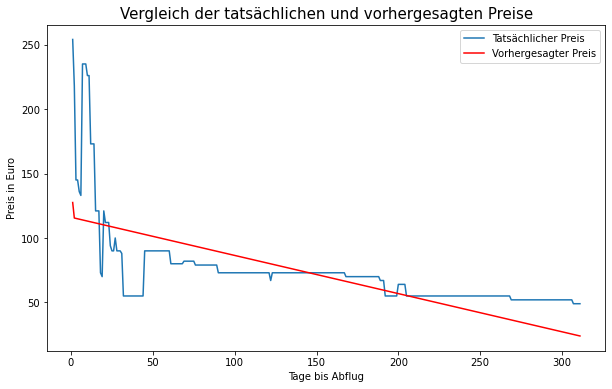

In [33]:
vergleiche(linreg_model, X_reg, y_reg, onehot_encoder_reg, abflugdaten)

**Exkurs:**

Bevor die lineare Regression aufgrund der schlechten Ergebnisse verworfen wird, kann in einem weiteren Schritt eine polynomielle Regression getestet werden. Hierfür werden die Trainingsdaten in einen erweiterten Merkmalsraum abgebildet. Anschließend wird der Algorithmus der linearen Regression erneut trainiert.

In [34]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_train_reg.copy())
poly_model = LinearRegression()
poly_model = vorhersage(poly_model, X_poly, y_train_reg)

Trainingsdaten-Score:  0.490492563864511

Qualitätsmaße des Trainingsdatensatzes: 
MAE:  21.460495983639237
MSE:  1696.1175999520085
RMSE:  4.632547461563587


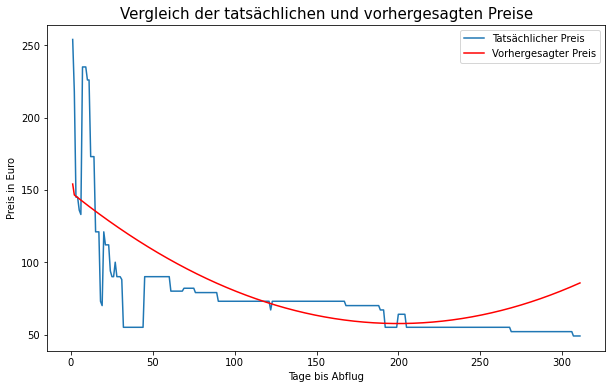

In [35]:
vergleiche(poly_model, X_reg, y_reg, onehot_encoder_reg, abflugdaten, poly)

Es ist zu erkennen, dass die Ergebnisse tatsächlich schon deutlich besser werden. Allerdings ist eine Genauigkeit von 49.05% weiterhin zu schlecht, um den Algorithmus weiter zu betrachten. Auch der MSE ist weiterhin sehr hoch, was auf stark abweichende Werte hindeutet. Man könnte versuchen, die Dimension des Merkmalsraums zu vergrößern, allerdings erhöht sich dadurch die Anzahl der Attribute enorm, wobei eine deutlich bessere Anpassung nicht zu erwarten ist. Aus diesem Grund findet keine weitere Anpassung des Algorithmus statt.

## 5.2. Entscheidungsbäume <a class="anchor" id="entscheidungsbaeume"></a>

Trainieren des Modells:

In [36]:
from sklearn.tree import DecisionTreeRegressor

print("--------- Entscheidungsbaum (Regression) ---------")
print()
dec_reg_model = DecisionTreeRegressor()
dec_reg_model = vorhersage(dec_reg_model, X_train_reg, y_train_reg)
kreuzvalidierung(dec_reg_model, X_train_reg, y_train_reg)

--------- Entscheidungsbaum (Regression) ---------

Trainingsdaten-Score:  0.7176866117136012

Qualitätsmaße des Trainingsdatensatzes: 
MAE:  11.965336830114705
MSE:  939.8031758015663
RMSE:  3.4590947992379024

Qualitätsmaße nach Kreuzvalidierung: 
Scores der 10 Durchläufe:  [50.03380522 47.17234816 50.18712394 48.35918714 47.80902371 48.81000746
 46.51365727 48.86623474 48.62968675 43.65474672]
Mittelwert:  48.00358211133086
Standardabweichung:  1.8073091130825623


Die Ergebnisse sehen im Vergleich zur linearen Regression schon deutlich besser aus. Die Vorhersagegenauigkeit für den bekannten Trainingsdatensatz liegt bei 71.77% und die mittlere Abweichung vom tatsächlichen Wert liegt bei 11.97 Euro. Die Werte nach der Kreuzvalidierung sehen schon etwas schlechter aus, was auf ein Overfitting der Trainingsdaten hindeutet.

Es soll nun versucht werden, den Algorithmus durch geeignete Hyperparameter zu verbessern, indem der RMSE minimiert wird. Zunächst wird die aktuelle Tiefe und die Anzahl der Blätter zur Orientierung bestimmt, um die Hyperparameter in geeigneter Weise anzupassen. Anschließend werden mit Hilfe einer Gittersuche alle möglichen Kombinationen der angegebenen Hyperparameter trainiert. Die beste Kombination wird ausgegeben.


In [37]:
#Tiefe des erzeugten Baumes ausgeben
print("Tiefe: ", dec_reg_model.get_depth())
print("Anzahl der Blätter: ", dec_reg_model.get_n_leaves())

Tiefe:  33
Anzahl der Blätter:  11767


In [38]:
#Erstelle zu testende Hyperparameter
param_grid = [{"criterion": ["squared_error", "poisson"], 
               "max_depth": [10, 20, 30],
              "min_samples_split": [2, 4, 6]}]

#Führe Gittersuche durch und gebe die Ergebnisse aus
gittersuche(dec_reg_model, param_grid, X_train_reg, y_train_reg)

Alle Ergebnisse der Gittersuche:
38.78490916269553 {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 2}
38.68815417010966 {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 4}
38.4373655693216 {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 6}
48.05209753697951 {'criterion': 'squared_error', 'max_depth': 20, 'min_samples_split': 2}
47.2605662125107 {'criterion': 'squared_error', 'max_depth': 20, 'min_samples_split': 4}
44.78533056088738 {'criterion': 'squared_error', 'max_depth': 20, 'min_samples_split': 6}
48.11295630102254 {'criterion': 'squared_error', 'max_depth': 30, 'min_samples_split': 2}
47.51236939502151 {'criterion': 'squared_error', 'max_depth': 30, 'min_samples_split': 4}
44.8645327063887 {'criterion': 'squared_error', 'max_depth': 30, 'min_samples_split': 6}
51.76048777726297 {'criterion': 'poisson', 'max_depth': 10, 'min_samples_split': 2}
51.65916951200714 {'criterion': 'poisson', 'max_depth': 10, 'min_samples_spl

Es wird ein neues Modell trainiert, das nun die optimierten Hyperparameter verwendet.

In [39]:
#Trainiere den Algorithmus erneut, aber mit verbesserten Hyperparametern
dec_reg_model_opt = DecisionTreeRegressor(max_depth=10, min_samples_split=6)
dec_reg_model_opt = vorhersage(dec_reg_model_opt, X_train_reg, y_train_reg)
kreuzvalidierung(dec_reg_model_opt, X_train_reg, y_train_reg)

Trainingsdaten-Score:  0.6432372087774025

Qualitätsmaße des Trainingsdatensatzes: 
MAE:  15.436379908530448
MSE:  1187.6404666245915
RMSE:  3.9289158693627493

Qualitätsmaße nach Kreuzvalidierung: 
Scores der 10 Durchläufe:  [40.1338458  38.42809281 39.57839834 36.72214262 38.10788608 38.91462527
 35.91478197 37.81745091 39.11790328 35.8066154 ]
Mittelwert:  38.05417424773493
Standardabweichung:  1.4185117066040949


Nun ist zu erkennen, dass die Ergebnisse auf den Trainingsdaten mit 64.32% zwar schlechter geworden sind, allerdings ist das Ziel, ein allgemeines Modell zu erzeugen, das bestmöglich auf unbekannten Daten funktioniert. Nach der Kreuzvalidierung ist zu erkennen, dass der RMSE deutlich geringer geworden ist. Das heißt, das Modell wurde verallgemeinert und funktioniert besser auf unbekannten Daten. Der RMSE hat sich von 48.00 auf 38.05 verbessert.

Da dieses nun das beste getestete Modell ist, soll dieses nun auf die unbekannten Testdaten angewendet werden. Zunächst wird das erste trainierte Modell auf die Testdaten angewendet, anschließend wird das optimierte Modell verwendet.

In [40]:
print("Erstes Modell:")
print()
testergebnisse(dec_reg_model, X_test_reg, y_test_reg)
print()
print("Optimiertes Modell: ")
print()
testergebnisse(dec_reg_model_opt, X_test_reg, y_test_reg)

Erstes Modell:

Testdaten-Score:  0.30099497503765826

Qualitätsmaße des Testdatensatzes: 
MAE:  18.782404464222648
MSE:  2256.2513626945447
RMSE:  4.333867148889389

Optimiertes Modell: 

Testdaten-Score:  0.5773704376734956

Qualitätsmaße des Testdatensatzes: 
MAE:  16.409345923646697
MSE:  1364.1654807353445
RMSE:  4.050845087589341


Das optimierte Modell hat eine Genauigkeit von ca. 57.74% auf unbekannte Daten, was im Gegensatz zum ersten Modell (mit ca. 30.10%) schon deutlich besser ist. Insgesamt hat sich die Optimierung gelohnt, da neben dem Score auch der MSE enorm gesunken ist und auch die tatsächliche Abweichung ist von 18.78 Euro auf 16.41 Euro gesunken.
Allerdings ist der MSE auch weiterhin sehr hoch und deutet auf hohe Abweichungen der Vorhersagen. Dies ist kein optimales Ergebnis für eine möglichst genaue Vorhersage.

Die vorhergesagten Daten sollen nun anhand des beispielhaften Fluges graphisch dargestellt werden.

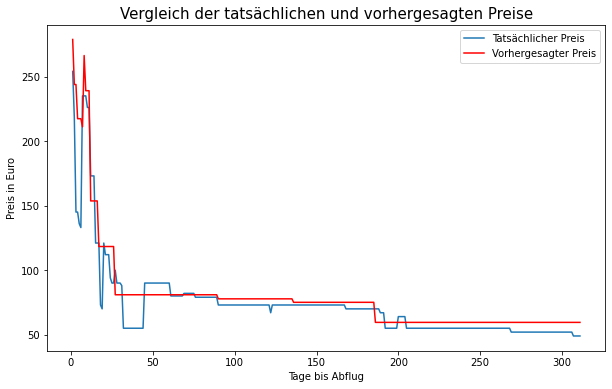

In [41]:
vergleiche(dec_reg_model_opt, X_reg, y_reg, onehot_encoder_reg, abflugdaten)

Die Vorhersagen sind deutlich näher an den tatsächlichen Preisen als bei der linearen Regression. Dennoch sind teils sehr große Abweichungen zu erkennen.

## 5.3. Random Forest <a class="anchor" id="random-forest"></a>

Zunächst wird wieder das Modell trainiert:

In [42]:
from sklearn.ensemble import RandomForestRegressor

print("--------- Random Forest (Regression) ---------")
print()
random_reg_model = RandomForestRegressor()
random_reg_model = vorhersage(random_reg_model, X_train_reg, y_train_reg)
kreuzvalidierung(random_reg_model, X_train_reg, y_train_reg)

--------- Random Forest (Regression) ---------

Trainingsdaten-Score:  0.7141146414729518

Qualitätsmaße des Trainingsdatensatzes: 
MAE:  12.22954795834464
MSE:  951.6940358008287
RMSE:  3.4970770592517173

Qualitätsmaße nach Kreuzvalidierung: 
Scores der 10 Durchläufe:  [46.1027802  43.3701576  45.60043486 44.28126678 43.83240029 44.95316168
 42.40263953 44.90438416 44.03373678 40.60436282]
Mittelwert:  44.00853247055434
Standardabweichung:  1.526293837382801


Der Score ähnelt dem des Entscheidungsbaumes. Es wird nun versucht, das Model zu optimieren. Hierfür wurden bereits für den Entscheidungsbaum die optimalen Parameter bestimmt, die nun auch für den Random Forest verwendet werden sollen. Aufgrund der unverhältnismäßig langen Rechenzeiten ist ein Vergleich zwischen der Anzahl an Entscheidungsbäumen leider nicht durchführbar. Daher bleibt es bei der Standardanzahl von 100 Entscheidungsbäumen im Random Forest.

Das optimierte Modell wird traininert. Anschließend werden die Ergebnisse verglichen.

In [43]:
#Trainiere mit verbesserten Hyperparametern
random_reg_model_opt = RandomForestRegressor(max_depth=10, min_samples_split=6)
random_reg_model_opt = vorhersage(random_reg_model_opt, X_train_reg, y_train_reg)
kreuzvalidierung(random_reg_model_opt, X_train_reg, y_train_reg)

Trainingsdaten-Score:  0.6653427729452723

Qualitätsmaße des Trainingsdatensatzes: 
MAE:  14.822758417856146
MSE:  1114.0524602818894
RMSE:  3.8500335606142637

Qualitätsmaße nach Kreuzvalidierung: 
Scores der 10 Durchläufe:  [39.26235332 36.85601151 38.37717181 36.00217046 36.8727973  37.28587184
 34.10101733 36.18801988 37.3115001  34.76410951]
Mittelwert:  36.70210230608953
Standardabweichung:  1.4629205332880144


Wie schon beim Entscheidungsbaum, wirkt das optimierte Modell zunächst schlechter. Der Trainingsdaten-Score ist niedriger und auch der MAE ist höher. Allerdings ist viel wichtiger, dass die RMSE-Werte nach der Kreuzvalidierung sinken. Dies deutet auf ein besseres Modell hin, da es besser verallgemeinert und daher besser auf nicht bekannten Daten arbeitet. Das zuerst trainierte Modell funktioniert lediglich auf dem Trainingsdatensatz gut (Overfitting). Aufgrund der niedrigeren RMSE-Werte nach der Kreuzvalidierung ist das optimierte Modell tatsächlich vielversprechender.

In [44]:
print("Erstes Modell:")
print()
testergebnisse(random_reg_model, X_test_reg, y_test_reg)
print()
print("Optimiertes Modell: ")
print()
testergebnisse(random_reg_model_opt, X_test_reg, y_test_reg)

Erstes Modell:

Testdaten-Score:  0.39575680373873934

Qualitätsmaße des Testdatensatzes: 
MAE:  17.602247872406725
MSE:  1950.3787330238783
RMSE:  4.195503291907507

Optimiertes Modell: 

Testdaten-Score:  0.5958423590754123

Qualitätsmaße des Testdatensatzes: 
MAE:  15.827113417569246
MSE:  1304.5417350592581
RMSE:  3.978330481190476


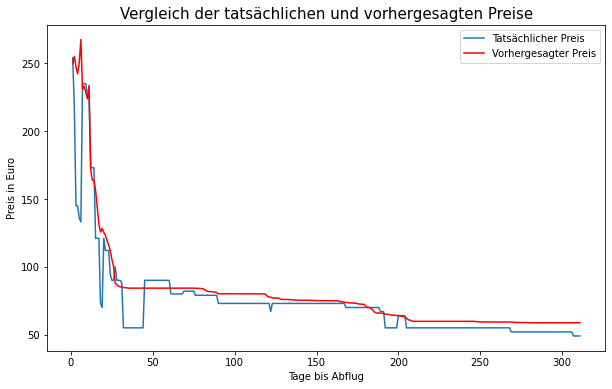

In [45]:
vergleiche(random_reg_model_opt, X_reg, y_reg, onehot_encoder_reg, abflugdaten)

Insgesamt ähnelt die graphische Darstellung der des Entscheidungsbaumes. Die vorhergesagten Daten wirken lediglich etwas genauer, wobei auch hier teils große Abweichungen zu erkennen sind.

## 5.4. k-Nearest Neighbors <a class="anchor" id="k-nearest-neighbor"></a>

Trainieren des Modells:

In [46]:
from sklearn.neighbors import KNeighborsRegressor 

print("--------- k-Nearest Neighbours (Regression) ---------")
print()
neighbors_reg_model = KNeighborsRegressor ()
neighbors_reg_model = vorhersage(neighbors_reg_model, X_train_reg, y_train_reg)
kreuzvalidierung(neighbors_reg_model, X_train_reg, y_train_reg)

--------- k-Nearest Neighbours (Regression) ---------

Trainingsdaten-Score:  0.6773646807604785

Qualitätsmaße des Trainingsdatensatzes: 
MAE:  13.271662825505313
MSE:  1074.0322996635673
RMSE:  3.64302934732968

Qualitätsmaße nach Kreuzvalidierung: 
Scores der 10 Durchläufe:  [41.76195169 39.15353281 39.85960687 39.3317618  40.01190829 39.83469725
 37.84138328 40.2259968  39.17032665 37.07344191]
Mittelwert:  39.42646073521432
Standardabweichung:  1.2242968477060627


Optimierung der Parameter:

In [47]:
#Erstelle zu testende Hyperparameter
param_grid = [{"n_neighbors": [3,5,7],
              "weights": ["uniform", "distance"]}]

#Führe Gittersuche durch und gebe die Ergebnisse aus
gittersuche(neighbors_reg_model, param_grid, X_train_reg, y_train_reg)

Alle Ergebnisse der Gittersuche:
41.775692855139795 {'n_neighbors': 3, 'weights': 'uniform'}
47.80217682751148 {'n_neighbors': 3, 'weights': 'distance'}
38.86300562055728 {'n_neighbors': 5, 'weights': 'uniform'}
47.838328902327255 {'n_neighbors': 5, 'weights': 'distance'}
38.38589612178061 {'n_neighbors': 7, 'weights': 'uniform'}
47.93993453654248 {'n_neighbors': 7, 'weights': 'distance'}

Die beste Kombination lautet:  KNeighborsRegressor(n_neighbors=7)


Trainieren des optimierten Modells und Darstellung der Ergebnisse:

In [48]:
#Wende den Algorithmus erneut an, aber mit verbesserten Hyperparametern
neighbors_reg_model_opt = KNeighborsRegressor (n_neighbors=7)
neighbors_reg_model_opt = vorhersage(neighbors_reg_model_opt, X_train_reg, y_train_reg)
kreuzvalidierung(neighbors_reg_model_opt, X_train_reg, y_train_reg)

Trainingsdaten-Score:  0.6677464134022535

Qualitätsmaße des Trainingsdatensatzes: 
MAE:  13.866104305506674
MSE:  1106.0508952528003
RMSE:  3.72372183514111

Qualitätsmaße nach Kreuzvalidierung: 
Scores der 10 Durchläufe:  [40.47446025 38.39188755 39.41854136 37.54057145 38.5584717  39.46566044
 35.95973263 38.37747888 38.1456791  35.53854726]
Mittelwert:  38.187103061421126
Standardabweichung:  1.448964886809358


In [49]:
print("Erstes Modell:")
print()
testergebnisse(neighbors_reg_model, X_test_reg, y_test_reg)
print()
print("Optimiertes Modell: ")
print()
testergebnisse(neighbors_reg_model_opt, X_test_reg, y_test_reg)

Erstes Modell:

Testdaten-Score:  0.5144275077550202

Qualitätsmaße des Testdatensatzes: 
MAE:  16.166645475736388
MSE:  1567.3329349438438
RMSE:  4.0207767254271145

Optimiertes Modell: 

Testdaten-Score:  0.5555418081055452

Qualitätsmaße des Testdatensatzes: 
MAE:  16.015817515817513
MSE:  1434.6240231629843
RMSE:  4.001976701058805


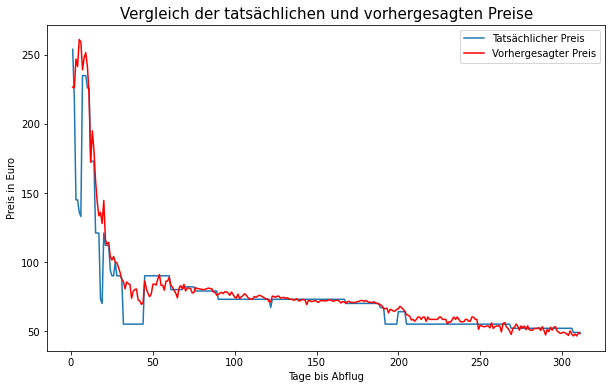

In [50]:
vergleiche(neighbors_reg_model_opt, X_reg, y_reg, onehot_encoder_reg, abflugdaten)

Im Vergleich zu den vorherigen Vergleichen erkennt man deutlich, dass die einzelnen Preise extrem stark schwanken und die Preise für jeden Tag unterschiedlich ausfallen. Insgesamt werden ähnlich schlechte Ergebnisse wie beim Entscheidungsbaum erzielt. 

## 5.5. Support Vector Machine <a class="anchor" id="svm"></a>

Trainieren des Modells:

In [51]:
from sklearn.svm import SVR

print("--------- SVM (Regression) ---------")
print()
svm_reg_model = SVR()
svm_reg_model = vorhersage(svm_reg_model, X_train_reg, y_train_reg)

--------- SVM (Regression) ---------

Trainingsdaten-Score:  0.1726626300654408

Qualitätsmaße des Trainingsdatensatzes: 
MAE:  26.42720805621439
MSE:  2754.1530794672326
RMSE:  5.140740030016533


Aufgrund des noch schlechteren Ergebnisses als bei der linearen Regression, wird die SVM für das Regressionsproblem direkt verworfen, ohne weitere Berechnungen oder Optimierungen durchzuführen. Eine Genauigkeit von 17.23% auf dem Trainingsdatensatz ist extrem schlecht, weshalb auch keine großartigen Verbesserungen zu erwarten sind. Auf die Kreuzvalidierung wurde aufgrund der langen Rechenzeiten und der sowieso schon schlechten Ergebnisse verzichtet.

## 5.6. Multilayer Perceptron <a class="anchor" id="mlp"></a>

Trainieren des Modells:

In [52]:
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")

print("--------- MLP (Regression) ---------")
print()
mlp_reg_model = MLPRegressor()
mlp_reg_model = vorhersage(mlp_reg_model, X_train_reg, y_train_reg)
kreuzvalidierung(mlp_reg_model, X_train_reg, y_train_reg)

--------- MLP (Regression) ---------

Trainingsdaten-Score:  0.6194447050006839

Qualitätsmaße des Trainingsdatensatzes: 
MAE:  16.137092118793685
MSE:  1266.8441868071677
RMSE:  4.017099963754162

Qualitätsmaße nach Kreuzvalidierung: 
Scores der 10 Durchläufe:  [38.40526089 35.93353203 37.9938291  35.17828718 36.52893426 37.50812254
 32.83122121 35.88864029 36.63473796 34.63254333]
Mittelwert:  36.153510877298096
Standardabweichung:  1.5838309102505512


An dieser Stelle fällt auf, dass die RMSE-Werte nach Kreuzvalidierung bereits deutlich besser ausfallen, als bei den vorherigen Modellen. 

Optimierung des Modells mit anschließendem Training und Darstellung der Ergebnisse:

In [53]:
#Erstelle zu testende Hyperparameter
param_grid = [{"hidden_layer_sizes": [(8,8,8),(64,64,64)],
              "max_iter": [100, 200, 500]}]

#Führe Gittersuche durch und gebe die Ergebnisse aus
gittersuche(mlp_reg_model, param_grid, X_train_reg, y_train_reg)

Alle Ergebnisse der Gittersuche:
38.056642306289426 {'hidden_layer_sizes': (8, 8, 8), 'max_iter': 100}
37.0828817002533 {'hidden_layer_sizes': (8, 8, 8), 'max_iter': 200}
37.55815766249243 {'hidden_layer_sizes': (8, 8, 8), 'max_iter': 500}
35.81021243998084 {'hidden_layer_sizes': (64, 64, 64), 'max_iter': 100}
35.6674646454048 {'hidden_layer_sizes': (64, 64, 64), 'max_iter': 200}
35.7278886947864 {'hidden_layer_sizes': (64, 64, 64), 'max_iter': 500}

Die beste Kombination lautet:  MLPRegressor(hidden_layer_sizes=(64, 64, 64))


In [54]:
#Trainiere mit verbesserten Hyperparametern
mlp_reg_model_opt = MLPRegressor(hidden_layer_sizes=(64, 64, 64))
mlp_reg_model_opt = vorhersage(mlp_reg_model_opt, X_train_reg, y_train_reg)
kreuzvalidierung(mlp_reg_model_opt, X_train_reg, y_train_reg)

Trainingsdaten-Score:  0.6492061620520961

Qualitätsmaße des Trainingsdatensatzes: 
MAE:  15.264722969009851
MSE:  1167.7702037305153
RMSE:  3.9070094662042796

Qualitätsmaße nach Kreuzvalidierung: 
Scores der 10 Durchläufe:  [37.61305936 34.97070514 36.66027652 34.98514206 36.09785126 37.15227983
 32.66713746 35.13398147 36.07552101 34.55244958]
Mittelwert:  35.5908403671328
Standardabweichung:  1.369291211619216


In [55]:
print("Erstes Modell:")
print()
testergebnisse(mlp_reg_model, X_test_reg, y_test_reg)
print()
print("Optimiertes Modell: ")
print()
testergebnisse(mlp_reg_model_opt, X_test_reg, y_test_reg)

Erstes Modell:

Testdaten-Score:  0.6089377528945559

Qualitätsmaße des Testdatensatzes: 
MAE:  16.14470094657781
MSE:  1262.272367752412
RMSE:  4.018046906965847

Optimiertes Modell: 

Testdaten-Score:  0.6174680647687991

Qualitätsmaße des Testdatensatzes: 
MAE:  15.592602703870304
MSE:  1234.7381911683342
RMSE:  3.948746978963112


Zu erkennen ist, dass sich das optimierte Modell nur minimal verbessert hat. Weitere Kombinationen, die ggf. noch bessere Ergebnisse erzielen würden, konnten aufgrund langer Rechenzeiten nicht erfolgen. 

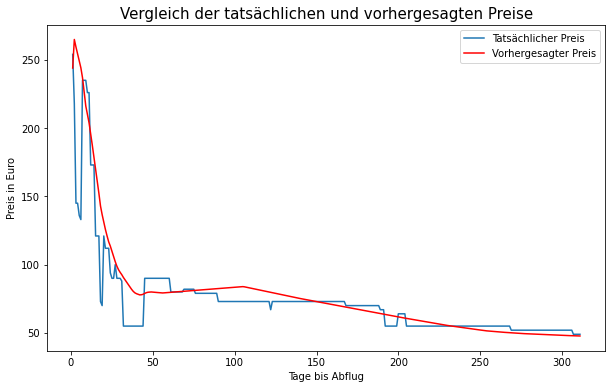

In [56]:
vergleiche(mlp_reg_model_opt, X_reg, y_reg, onehot_encoder_reg, abflugdaten)

In der graphischen Dartellung ist zu erkennen, dass die Vorhersagen weiterhin schlecht sind. Insbesondere kurz vor Abflug sind die Vorhersagen stark abweichend. Daher ist auch dieses Modell mit einer Genauigkeit von 61.75% nicht für Flugpreisvorhersagen geeignet, da diese zu sehr schwanken. 

Es wurden nun alle in der Abschlussarbeit vorgestellten (für Regressionsprobleme anwendbare) Algorithmen angewendet. Die besten Ergebnisse auf dem Testdatensatz erzielten:

- MLP mit einer Genauigkeit von 61.75% und einer mittleren absoluten Abweichung von 15.59 Euro
- Random Forest mit einer Genauigkeit von 59.58% und einer mittleren absoluten Abweichung von 15.83 Euro
- Entscheidungsbaum mit einer Genauigkeit von 57.74% und einer mittleren absoluten Abweichung von 16.41 Euro

## 6. Anwendung der ML-Algorithmen (Klassifikationsproblem) <a class="anchor" id="anwendung-klassifikationsproblem"></a>

Für das Klassifikationsproblem wurde bereits ein bereinigter Datensatz mit entsprechenden Labels erzeugt. Bevor die Modelle trainiert werden, soll zunächst verglichen werden, wie oft die jeweilige Klasse vorkommt. Sollte eine Klasse besonders oft vorkommen, könnten bereits dadurch gute Ergebnisse erzielt werden, indem immer auf dieselbe Klasse getippt wird.

In [57]:
df_klassifikation.groupby(["Buchen"]).count()["Preis"]

Buchen
0    16138
1    31049
Name: Preis, dtype: int64

Die Klassen teilen sich wie folgt auf: 34% "nicht buchen" (0) und 66% "buchen" (1). Es ist eine deutliche Mehrheit zu erkennen. Dennoch werden die Modelle trainiert und geschaut, ob diese bessere Vorhersagen treffen können, als wenn der Flug einfach immer sofort gebucht wird. Auf diese Weise würde man nämlich eine Genauigkeit von 66% erzielen. Sollte eine Genauigkeit von 66% nicht übertroffen werden, wäre eine Vorhersage dementsprechend sinnlos. 

Aufgrund der Erfahrungen mit dem Regressionsproblem, bei dem es teils zu sehr langen Rechenzeiten kam, wird für das Klassifikationsproblem darauf verzichtet, alle Modelle zu optimieren. Stattdessen werden zunächst alle Modelle mit Hilfe der Trainingsdaten trainiert und ein Qualitätsmaß bestimmt. Dieses Qualitätsmaß gibt an, wie viel Prozent der Daten korrekt klassifiziert wurden. Um ein Overfitting zu vermeiden, wird (wie schon zuvor bei der Regression) eine Kreuzvalidierung mit zehn Folds durchgeführt. Für alle zehn Durchläufe wird die Genauigkeit in Prozent ausgegeben. Anhand dieser Ergebnisse werden die drei besten Modelle weiter optimiert, während die anderen Modelle nicht weiter berücksichtigt werden.

## 6.1. Trainieren aller Algorithmen <a class="anchor" id="trainieren-aller-algorithmen"></a>

In [58]:
from sklearn.naive_bayes import GaussianNB

print("--------- Naiver Bayes-Klassifikator ---------")
print()
naiver_bayes_model = GaussianNB()
naiver_bayes_model = naiver_bayes_model.fit(X_train_klas, y_train_klas)
print("Ergebnis nach Kreuzvalidierung: ")
cross_val_score(naiver_bayes_model, X_train_klas, y_train_klas, cv=10, scoring="accuracy")

--------- Naiver Bayes-Klassifikator ---------

Ergebnis nach Kreuzvalidierung: 


array([0.65721854, 0.66119205, 0.66039735, 0.66410596, 0.66807947,
       0.66516556, 0.6805298 , 0.66410596, 0.65907285, 0.66958135])

In [59]:
from sklearn.tree import DecisionTreeClassifier
print("--------- Entscheidungsbaum (Klassifikation) ---------")
print()
dec_klas_model = DecisionTreeClassifier()
dec_klas_model = dec_klas_model.fit(X_train_klas, y_train_klas)
print("Ergebnis nach Kreuzvalidierung: ")
cross_val_score(dec_klas_model, X_train_klas, y_train_klas, cv=10, scoring="accuracy")

--------- Entscheidungsbaum (Klassifikation) ---------

Ergebnis nach Kreuzvalidierung: 


array([0.89801325, 0.90966887, 0.90437086, 0.90331126, 0.90384106,
       0.90649007, 0.90066225, 0.90807947, 0.90675497, 0.90328564])

In [60]:
from sklearn.ensemble import RandomForestClassifier

print("--------- Random Forest (Klassifikation) ---------")
print()
random_klas_model = RandomForestClassifier()
random_klas_model = random_klas_model.fit(X_train_klas, y_train_klas)
print("Ergebnis nach Kreuzvalidierung: ")
cross_val_score(random_klas_model, X_train_klas, y_train_klas, cv=10, scoring="accuracy")

--------- Random Forest (Klassifikation) ---------

Ergebnis nach Kreuzvalidierung: 


array([0.91205298, 0.9194702 , 0.91655629, 0.91390728, 0.9181457 ,
       0.91496689, 0.91470199, 0.91735099, 0.9210596 , 0.9154743 ])

In [61]:
from sklearn.neighbors import KNeighborsClassifier

print("--------- k-Nearest Neighbours (Klassifikation) ---------")
print()
neighbors_klas_model = KNeighborsClassifier()
neighbors_klas_model = neighbors_klas_model.fit(X_train_klas, y_train_klas)
print("Ergebnis nach Kreuzvalidierung: ")
cross_val_score(neighbors_klas_model, X_train_klas, y_train_klas, cv=10, scoring="accuracy")

--------- k-Nearest Neighbours (Klassifikation) ---------

Ergebnis nach Kreuzvalidierung: 


array([0.84980132, 0.84768212, 0.85112583, 0.84635762, 0.84423841,
       0.85350993, 0.85377483, 0.85086093, 0.8397351 , 0.84870164])

In [62]:
from sklearn.svm import SVC

print("--------- SVM (Klassifikation) ---------")
print()
svm_klas_model = SVC()
svm_klas_model = svm_klas_model.fit(X_train_klas, y_train_klas)
print("Ergebnis nach Kreuzvalidierung: ")
cross_val_score(svm_klas_model, X_train_klas, y_train_klas, cv=10, scoring="accuracy")

--------- SVM (Klassifikation) ---------

Ergebnis nach Kreuzvalidierung: 


array([0.68874172, 0.69271523, 0.68794702, 0.68927152, 0.6786755 ,
       0.68370861, 0.68794702, 0.69695364, 0.6786755 , 0.68574457])

In [63]:
from sklearn.neural_network import MLPClassifier

print("--------- MLP (Klassifikation) ---------")
print()
mlp_klas_model = MLPClassifier()
mlp_klas_model = mlp_klas_model.fit(X_train_klas, y_train_klas)
print("Ergebnis nach Kreuzvalidierung: ")
cross_val_score(mlp_klas_model, X_train_klas, y_train_klas, cv=10, scoring="accuracy")

--------- MLP (Klassifikation) ---------

Ergebnis nach Kreuzvalidierung: 


array([0.83655629, 0.82172185, 0.8402649 , 0.85589404, 0.83788079,
       0.8405298 , 0.8413245 , 0.84529801, 0.84794702, 0.84764176])

Die drei besten Modell sind demnach:

- Entscheidungsbaum mit 90.44%
- Random Forest mit 91.64%
- k-Nearest Neighbours mit 84.86%

Diese drei Algorithmen werden nun optimiert, um genauere Vorhersagen zu treffen. Die Optimierung erfolgt auf die gleiche Weise wie beim Regressionsproblem. Mit Hilfe einer Gittersuche werden die besten Hyperparameter bestimmt. Anschließend wird das optimierte Modell trainiert und auf den Testdaten angewendet.

## 6.2. Entscheidungsbäume <a class="anchor" id="entscheidungsbaeume-2"></a>

Gittersuche:

In [64]:
#Erstelle zu testende Hyperparameter
param_grid = [{"criterion": ["gini", "entropy"], 
               "max_depth": [10, 20, 30],
              "min_samples_split": [2, 4, 6]}]

#Führe Gittersuche durch und gebe die Ergebnisse aus
gittersuche(dec_klas_model, param_grid, X_train_klas, y_train_klas, methode="accuracy")

Alle Ergebnisse der Gittersuche:
0.8499034072316933 {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
0.8498769206745511 {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 4}
0.8495855194188258 {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 6}
0.9050836398663391 {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}
0.9033616908164671 {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 4}
0.9034676230087051 {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 6}
0.9032292510125897 {'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 2}
0.9011099720238374 {'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 4}
0.9016132622276185 {'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 6}
0.8386186249834415 {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
0.8389365198144748 {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 4}
0.8387245887574248 {'criterion': 'entropy', 'max_depth': 10

Trainiere optimiertes Modell:

In [65]:
dec_klas_model_opt = DecisionTreeClassifier(criterion="entropy", max_depth=20)
dec_klas_model_opt = dec_klas_model_opt.fit(X_train_klas, y_train_klas)
print("Ergebnis nach Kreuzvalidierung: ")
cross_val_score(dec_klas_model_opt, X_train_klas, y_train_klas, cv=10, scoring="accuracy")

Ergebnis nach Kreuzvalidierung: 


array([0.90754967, 0.91231788, 0.91019868, 0.90304636, 0.91019868,
       0.91178808, 0.90225166, 0.90860927, 0.91099338, 0.90593535])

Durch die Kreuzvalidierung konnte das Modell lediglich um ca. 0.4% verbessert werden. Nun kann es auf die Testdaten angewendet werden, wobei zunächst die Genauigkeit in Prozent angegeben wird. Darüber hinaus wird die Konfusionsmatrix dargestellt, die die Anzahl der folgenden Ergebnisse zeigt:

- richtig-negativ
- falsch-positiv
- falsch-negativ
- richtig-positiv

In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

#Definiere Funktion, die die Genauigkeit ausgibt und anschließend die Konfusionsmatrix
#graphisch darstellt

def ergebnis_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Genauigkeit: ", accuracy_score(y_test, y_pred))
    print()
    print("Konfusionsmatrix des Testdatensatzes:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

Entscheidungsbaum nach Optimierung: 

Genauigkeit:  0.9066539521084975

Konfusionsmatrix des Testdatensatzes:


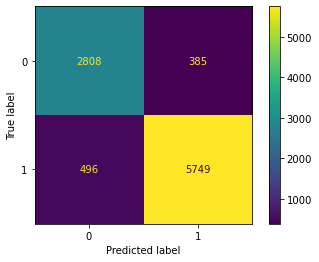

In [67]:
#Ergebnisse ausgeben
print("Entscheidungsbaum nach Optimierung: ")
print()
ergebnis_matrix(dec_klas_model, X_test_klas, y_test_klas)

## 6.3. Random Forest <a class="anchor" id="random-forest-2"></a>

Aufgrund der extrem langen Rechenzeiten wird zur Optimierung lediglich die Anzahl an verwendeten Bäumen geprüft. Getestet werden Random Forests, die aus 50, 100 oder 200 Entscheidungsbäumen bestehen.

Da der Random Forest aus vielen Entscheidungsbäumen besteht, werden zudem die für den Entscheidungsbaum besten Parameter verwendet (criterion = entropy und max_depth = 20).

In [68]:
#Erstelle zu testende Hyperparameter
param_grid = [{"n_estimators": [50, 100, 200],
                "criterion": ["entropy"], 
               "max_depth": [20],
              "min_samples_split": [2, 4, 6]}]

#Führe Gittersuche durch und gebe die Ergebnisse aus
gittersuche(random_klas_model, param_grid, X_train_klas, y_train_klas, methode="accuracy")

Alle Ergebnisse der Gittersuche:
0.9169779743643955 {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}
0.9170838819930539 {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
0.9170044609215378 {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
0.916262682921908 {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 50}
0.9169779427826501 {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 100}
0.9173223136435773 {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 200}
0.9161037425245571 {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 6, 'n_estimators': 50}
0.9166865239815106 {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 6, 'n_estimators': 100}
0.9162626443219969 {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 6, 'n_estimators': 200}

Die beste Kombin

Optimiere das Modell:

In [69]:
random_klas_model_opt = RandomForestClassifier(criterion="entropy", max_depth=20, min_samples_split=4, 
                                              n_estimators=50)
random_klas_model_opt = random_klas_model.fit(X_train_klas, y_train_klas)
print("Ergebnis nach Kreuzvalidierung: ")
cross_val_score(random_klas_model_opt, X_train_klas, y_train_klas, cv=10, scoring="accuracy")

Ergebnis nach Kreuzvalidierung: 


array([0.91496689, 0.9194702 , 0.91788079, 0.91602649, 0.9181457 ,
       0.91576159, 0.91364238, 0.9197351 , 0.9192053 , 0.91600424])

Auch in diesem Fall konnte eine Verbesserung der Genauigkeit um lediglich ca. 0.1% erreicht werden. Es folgt die Konfusionsmatrix:

Random Forest nach Optimierung: 

Genauigkeit:  0.9166136893409621

Konfusionsmatrix des Testdatensatzes:


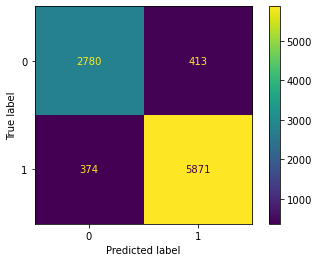

In [70]:
#Ergebnisse ausgeben
print("Random Forest nach Optimierung: ")
print()
ergebnis_matrix(random_klas_model_opt, X_test_klas, y_test_klas)

## 6.4. k-Nearest Neighbors <a class="anchor" id="neigh"></a>

Gittersuche:

In [71]:
#Erstelle zu testende Hyperparameter, aufgrund zu langer Rechenzeiten kann nur die Anzahl der Nachbarn 
#optimiert werden
param_grid = [{"n_neighbors": [3,5,7,9]}]

#Führe Gittersuche durch und gebe die Ergebnisse aus
gittersuche(neighbors_klas_model, param_grid, X_train_klas, y_train_klas, methode="accuracy")

Alle Ergebnisse der Gittersuche:
0.8603405599969822 {'n_neighbors': 3}
0.8446315787626798 {'n_neighbors': 5}
0.8336909743758 {'n_neighbors': 7}
0.8236244158473689 {'n_neighbors': 9}

Die beste Kombination lautet:  KNeighborsClassifier(n_neighbors=3)


Optimiertes Modell:

In [72]:
neighbors_klas_model_opt = KNeighborsClassifier(n_neighbors=3)
neighbors_klas_model_opt = neighbors_klas_model_opt.fit(X_train_klas, y_train_klas)
print("Ergebnis nach Kreuzvalidierung: ")
cross_val_score(neighbors_klas_model_opt, X_train_klas, y_train_klas, cv=10, scoring="accuracy")

Ergebnis nach Kreuzvalidierung: 


array([0.86966887, 0.86807947, 0.87629139, 0.86940397, 0.86437086,
       0.86807947, 0.86966887, 0.87205298, 0.86437086, 0.86777954])

Genauigkeit:  0.8786819241364696

Konfusionsmatrix des Testdatensatzes:


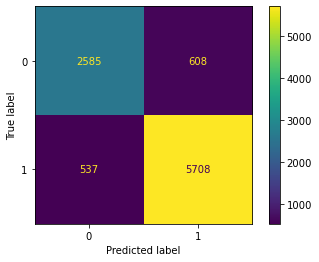

In [73]:
ergebnis_matrix(neighbors_klas_model_opt, X_test_klas, y_test_klas)

Das Modell konnte um ca. 2% optimiert werden, allerdings sind die Ergebnisse trotzdem schlechter als beim Random Forest. 

Das beste Ergebnis konnte demnach mit dem Random Forest mit einer Genauigkeit von ca. 91.66% erzielt werden. Dies ist ein gutes Ergebnis, das im weiteren Verlauf an einer Simulation angewendet werden soll.

## 7. Simulation von Flugbuchungen <a class="anchor" id="simulation"></a>

Zum Abschluss soll das beste Modell (jeweils für Regression und Klassifikation) angewendet werden. Hierfür werden Flugbuchungen von Passagieren simuliert und die Ersparnis in Prozent berechnet, wenn dieser Passagier auf die Empfehlung der Vorhersage hört.

## 7.1. Regressionsproblem <a class="anchor" id="simreg"></a>

Das Modell sagt die noch kommenden Flugpreise vorher. Daher kann für einen gewünschten Flug bestimmt werden, wann voraussichtlich der günstigste Flug angeboten wird. Diese Information kann genutzt werden, um das günstigste noch kommende Angebot zu buchen.

Anmerkung: Der Zeitpunkt für den günstigsten vorhergesagten Flug wird nicht explizit bestimmt! Die DataFrames werden zusammengefügt, wodurch die tatsächlichen und vorhergesagten Preise dem selben DataFrame entnommen werden können. Dies ist für die Simulation ausreichend, in der Praxis wäre es allerdings sinnvoll, den Zeitpunkt auszugeben.

Bei der Simulation wird wie folgt vorgegangen:
1. Es werden 100 zufällige Datenpunkte des Datensatzes ausgewählt. Ein Datenpunkt entspricht dem Flug, den der Kunde buchen möchte und dem Zeitpunkt, zu dem er nach einem Flug sucht.
2. Es werden alle nachfolgenden Preise für diesen Flug bis einen Tag vor Abflug bestimmt.
3. Anschließend wird genau an dem Tag gebucht, an dem der günstigste Preis vorhergesagt wurde. Allerdings zum tatsächlichen Preis, nicht zum vorhergesagten Preis.

Auf diese Weise kann die Ersparnis für diese 100 zufälligen Buchungen bestimmt werden. Dies ist die Differenz zwischen dem Preis, wenn sofort gebucht wird (Datenpunkt aus Schritt 1.) und dem Preis, der an dem vorhergesagten Tag buchbar ist (tatsächlicher Preis!). Diese Ersparnis wird in Prozent bestimmt.

Aufgrund der zuvor rein zufällig gewählten Aufteilung des Trainings- und Testdatensatze wird im Folgenden wieder der gesamte Datensatz verwendet. Würde lediglich der Testdatensatz genutzt werden, wären nicht alle Flüge lückenlos vorhanden. Um dennoch ein repräsentatives Ergebnis zu erhalten, wird die Simulation 50 mal durchgespielt, sodass am Ende 5000 Flugbuchungen simuliert wurden. Dies entspricht einem Anteil von ca. 10% der gesamten Daten. Anschließend werden die Ergebnisse ausgegeben und visualisiert. 

In [74]:
#Zusammenführen der bereinigten Daten mit den Abflugdaten, da dies zur Identifikation der Flüge notwendig ist
simu_daten = pd.concat([df_bereinigt, abflugdaten], axis=1)
simu_daten.head()

,Flugnummer,Airline,Zielflughafen,Wochentag des Abflugs,Abflugzeit,Tage bis Abflug,Preis,Abflugdatum
0,EW 7460,Eurowings,LHR,Sonntag,nachmittags,109,98,2023-02-26
1,EW 7460,Eurowings,LHR,Sonntag,nachmittags,108,98,2023-02-26
2,EW 7460,Eurowings,LHR,Sonntag,nachmittags,107,98,2023-02-26
3,EW 7460,Eurowings,LHR,Sonntag,nachmittags,106,98,2023-02-26
4,EW 7460,Eurowings,LHR,Sonntag,nachmittags,105,98,2023-02-26


In [75]:
#Es wird eine Funktion definiert, die o.g. Vorgehen simuliert. Es werden 100 zufällige Buchungen simuliert.
#Zurückgegeben werden Zählervariablen, die die Anzahl gesparter, draufgezahlter und gleicher Preise speichert.
#Zudem wird eine Liste zurückgegeben, die die Ersparnis in % jeder Zufallsbuchung enthält, wenn
#auf die Empfehlung des Modells gehört wird
import random

def simuliere_regressionsproblem(gespart, draufgezahlt, gleich):
    
    #Listen für Preise (Preis sofort gebucht oder auf Empfehlung gehört)
    sofort_buchen = []
    auf_algo_hoeren = []

    #Bestimme 10 zufällige Datenpunkte aus dem Datensatz anhand des Indexes
    index = random.sample(simu_daten.index.tolist(),100)

    for i in index:
        #Suche alle noch kommenden Flugpreise für diesen Flug
        #Besorge den entsprechenden Flug im Datensatz (Kombination aus Flugnummer und Datum)
        #Nur Flüge, die näher dran sind am Abflug
        kommende_fluege = simu_daten.copy()
        kommende_fluege = kommende_fluege[(kommende_fluege["Flugnummer"] == simu_daten.loc[i]["Flugnummer"]) & 
                        (kommende_fluege["Abflugdatum"] == simu_daten.loc[i]["Abflugdatum"]) &
                       (kommende_fluege["Tage bis Abflug"] <= simu_daten.loc[i]["Tage bis Abflug"])]
    
        #Sage für alle kommenden Flüge die Preise mittels MLP-Modell vorher. 
        #Zunächst muss der Datensatz angepasst werden (Spalte "Abflugdatum" entfernen + one-hot-codierung)
        vorherzusagende_fluege = kommende_fluege.drop(["Abflugdatum"], axis=1)
        vorherzusagende_onehot = onehot_encoder_reg.transform(vorherzusagende_fluege)
    
        #Vorhersage
        vorh_preise = mlp_reg_model_opt.predict(vorherzusagende_onehot.drop(["Preis"], axis=1))
    
        #Füge vorhergesagte Preise in das gleiche DataFrame wie die restlichen Flugdaten für diesen Flug
        kommende_fluege["Vorhergesagter Preis"] = vorh_preise
    
        #Bestimme den Index des günstigsten Fluges und "buche" diesen
        index_preis = kommende_fluege["Vorhergesagter Preis"].idxmin()
    
        #Füge den aktuellen Preis der Liste hinzu, wenn sofort gebucht werden soll
        sofort_buchen.append((kommende_fluege.iloc[0]["Preis"]))
    
        #Füge den tatsächlichen Preis der Liste hinzu, wenn auf den Algorithmus gehört werden soll
        auf_algo_hoeren.append(kommende_fluege.loc[index_preis]["Preis"])
        
        #Passe die Zähler an
        if((kommende_fluege.iloc[0]["Preis"])) == ((kommende_fluege.loc[index_preis]["Preis"])):
            gleich = gleich+1
        elif((kommende_fluege.iloc[0]["Preis"])) > ((kommende_fluege.loc[index_preis]["Preis"])):
            gespart = gespart+1
        else:
            draufgezahlt = draufgezahlt+1
    
    #Bestimme die Ersparnisse und speicher diese in einer Liste
    ersparnisse = []
    
    #Gehe beide Listen mit den Preisen durch, bestimme die prozentuale Ersparnis
    for j in range(len(sofort_buchen)):
        diff = sofort_buchen[j] - auf_algo_hoeren[j]
        prozent = round(diff/sofort_buchen[j]*100, 2)
        ersparnisse.append(prozent)
    
    #Gebe Zähler und Liste mit prozentualer Ersparnis zurück
    return gespart, draufgezahlt, gleich, ersparnisse

In [76]:
#definiere Funktion, um Ergebnisse auszugeben
def sim_ergebnisse(gespart, draufgezahlt, gleich, differenzen):
    
    #Gebe die Ergebnisse aus
    print("Anzahl der Buchungen, bei denen der Preis gleich blieb: ", gleich)
    print("Anzahl der Buchungen, bei denen draufgezahlt wurde: ", draufgezahlt)
    print("Anzahl der Buchungen, bei denen gespart wurde: ", gespart)

    #Entferne alle Nullen aus der Liste, da nicht gespart wurde
    differenzen_pos = [dif for dif in differenzen if dif > 0]
    differenzen_neg = [dif for dif in differenzen if dif < 0]
    print()
    print("Anteil der Buchungen, bei denen draufgezahlt wurde: ", round((draufgezahlt)/(gespart+draufgezahlt+
                                                                                    gleich)*100,2), "%")
    print("Der durchschnittliche Aufpreis beträgt: ", -(round(sum(differenzen_neg)/len(differenzen_neg),2)), "%")
    print()
    print("Anteil der Buchungen, bei denen gespart wurde: ", round((gespart)/(gespart+draufgezahlt+gleich)*100,2), "%")
    print("Die durchschnittliche Ersparnis beträgt: ", round(sum(differenzen_pos)/len(differenzen_pos),2), "%")
    
    #Plotten der Ergebnisse im Histogram
    plt.hist([differenzen_pos + differenzen_neg], bins=5)
    plt.xlabel("Ersparnis in Prozent")
    plt.ylabel("Anzahl der Buchungen")
    plt.title("Verteilung der Ersparnisse")
    plt.show()
    return

Anzahl der Buchungen, bei denen der Preis gleich blieb:  3833
Anzahl der Buchungen, bei denen draufgezahlt wurde:  488
Anzahl der Buchungen, bei denen gespart wurde:  679

Anteil der Buchungen, bei denen draufgezahlt wurde:  9.76 %
Der durchschnittliche Aufpreis beträgt:  21.01 %

Anteil der Buchungen, bei denen gespart wurde:  13.58 %
Die durchschnittliche Ersparnis beträgt:  22.84 %


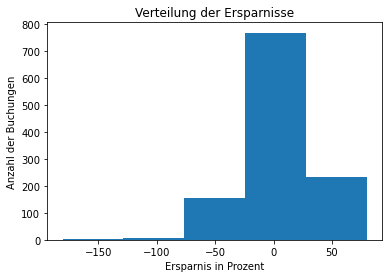

In [77]:
#Simuliere 50 mal und bestimme die Durchschnittswerte. Stelle die Ergebnisse graphisch dar.

#Zählervariablen
gespart = 0
draufgezahlt = 0
gleich = 0
differenzen = []

#Simuliere 50 mal jeweils 100 Buchungen
for i in range(50):
    gespart, draufgezahlt, gleich, differenz = simuliere_regressionsproblem(
        gespart, draufgezahlt, gleich)
    for d in differenz:
        differenzen.append(d)
#Gebe die Ergebnisse aus
sim_ergebnisse(gespart, draufgezahlt, gleich, differenzen)

Die Ergebnisse können obigem Histogramm entnommen werden. Hier wird die Anzahl der Buchungen (y-Achse) dargestellt, die einen bestimmten Prozentsatz (x-Achse) gespart haben, indem auf die Empfehlung des Modells gehört wurde. Ein negativer Prozentsatz bedeutet, dass die Buchung am Ende zu einem höheren Preis getätigt wurde, als wenn man sofort gebucht hätte.

Insgesamt ist zu erkennen, dass es nicht sinnvoll ist, auf die Vorhersagen des Modells zu vertrauen. In nur 13% aller Test-Buchungen wurde überhaupt Geld gespart. In 10% der Buchungen musste sogar mehr bezahlt werden, als wenn man sofort gebucht hätte. 

## 7.2. Klassifikationsproblem <a class="anchor" id="simklas"></a>

Auch für das Klassifikationsproblem sollen zufällige Buchungen simuliert werden, um die Ersparnis zu berechnen, wenn den Empfehlungen des Modells gefolgt wird. Hierfür werden erneut insgesamt 5000 zufällige Datenzeilen ausgewählt, die einen vom Kunden gewünschten Flug darstellen (insbesondere gekennzeichnet durch Flugnummer und Abflugdatum). Diese hohe Anzahl ist notwendig, um ein repräsentatives Ergebnis zu erhalten. Aufgrund der zufälligen Auswahl von Trainings- und Testdaten ist es nicht möglich, die Simulation allein auf den Testdaten durchzuführen, da zu viele Lücken vorhanden sind. Allerdings sei darauf hingewiesen, dass die Ergebnisse der Kreuzvalidierung auf dem Trainingsdatensatz (91.71%) dem Ergebnis des Testdatensatzes (91.66%) sehr nahe kommt, weshalb nicht von einem Over- oder Underfitting auszugehen ist.

Das Kundenverhalten soll wie folgt simuliert werden:

1. Betrachte den ausgewählten Flug, und bestimme Klassifikation (1 (buchen) / 0 (nicht buchen)).
2. Wenn 1, dann buche den Flug sofort.
3. Wenn 0, buche den Flug nicht und schaue am nachfolgenden Tag erneut nach dem Preis, beginne wieder mit Punkt 1.

In [78]:
#Zusammenführen der Klassifikations-Daten mit den Abflugdaten, da diese zur Identifikation der Flüge notwendig ist
simu_daten = pd.concat([df_klassifikation, abflugdaten], axis=1)
simu_daten.head()

,Flugnummer,Airline,Zielflughafen,Wochentag des Abflugs,Abflugzeit,Tage bis Abflug,Preis,Buchen,Abflugdatum
0,EW 7460,Eurowings,LHR,Sonntag,nachmittags,109,98,0,2023-02-26
1,EW 7460,Eurowings,LHR,Sonntag,nachmittags,108,98,0,2023-02-26
2,EW 7460,Eurowings,LHR,Sonntag,nachmittags,107,98,0,2023-02-26
3,EW 7460,Eurowings,LHR,Sonntag,nachmittags,106,98,0,2023-02-26
4,EW 7460,Eurowings,LHR,Sonntag,nachmittags,105,98,0,2023-02-26


In [97]:
#Es wird eine Funktion definiert, die o.g. Vorgehen simuliert. Es werden 100 zufällige Buchungen simuliert.
#Zurückgegeben werden Zählervariablen, die die Anzahl gesparter, draufgezahlter und gleicher Preise speichert.
#Zudem wird eine Liste zurückgegeben, die die Ersparnis in % jeder Zufallsbuchung enthält, wenn
#auf die Empfehlung des Modells gehört wird.
def simuliere_klassifikationsproblem(data, gespart, draufgezahlt, gleich):
    
    #Listen für Preise (Preis sofort gebucht oder auf Empfehlung gehört)
    sofort_buchen = []
    auf_algo_hoeren = []

    #Bestimme 10 zufällige Datenpunkte aus dem Datensatz anhand des Indexes
    index = random.sample(data.index.tolist(),100)
    
    #Gehe jeden Datenpunkt einzeln durch
    for i in index:
        #Abbruchbedingung auf 0 setzen
        abbruch = 0
        #Kopiere Datenzeile als dataframe
        zeile = data.loc[[i]].copy() 
        
        #Solange kein Flug gebucht wurde, wiederhole while-Schleife
        while(abbruch == 0):
            #Breche Schleife ab, wenn in "zeile" keine Daten sind. Dies passiert, wenn kein nachfolgender
            #Dateneintrag vorhanden ist, weil einige Daten fehlen -> berücksichtige die Buchung nicht
            if(zeile.empty):
                break
            
            #Entferne das Abflugdatum, codiere in onehot und entferne Label
            ohne_label = zeile.drop(["Abflugdatum"], axis=1)
            datenzeile_onehot = onehot_encoder_klas.transform(ohne_label)
            datenzeile_onehot = datenzeile_onehot.drop(["Buchen"], axis=1)
            
            #Sage für die ausgewählte Zeile vorher, ob buchen oder nicht buchen
            vorhersage = random_klas_model_opt.predict(datenzeile_onehot)
            
            #Wenn buchen, setze Abbruchkriterium, schreibe Preise in die Listen und erhöhe Zähler
            if(int(vorhersage) == 1):
                abbruch = 1
                sofort_buchen.append(int(data.loc[i]["Preis"]))  #tats. Preis des zufälligen Datenpunkts
                auf_algo_hoeren.append(int(zeile["Preis"]))            #tats. Preis zum vorhergesagten Tag
                
                #Passe die Zähler an
                if((int(data.loc[i]["Preis"])) == (int(zeile["Preis"]))):
                    gleich = gleich+1
                elif((int(data.loc[i]["Preis"])) > (int(zeile["Preis"]))):
                    gespart = gespart+1
                else:
                    draufgezahlt = draufgezahlt+1
            #Sonst finde den Datenpunkt am Folgetag und wiederhole Schleife mit diesem Datenpunkt
            else:
                tage = int(zeile["Tage bis Abflug"])
                #Die verringerte Anzahl der Tage muss mind. 1 betragen, sonst existiert der Datenpunkt nicht
                if(tage-1 >= 1):
                    zeile = pd.DataFrame(data[(simu_daten["Abflugdatum"] == data.loc[i]["Abflugdatum"]) &
                                      (data["Flugnummer"] == data.loc[i]["Flugnummer"]) &
                                      (data["Tage bis Abflug"] == tage-1)])
                else:
                    break
    
    #Bestimme die Ersparnisse und speicher diese in einer Liste
    ersparnisse = []
    
    #Gehe beide Listen mit den Preisen durch, bestimme die prozentuale Ersparnis
    for j in range(len(sofort_buchen)):
        diff = sofort_buchen[j] - auf_algo_hoeren[j]
        prozent = round(diff/sofort_buchen[j]*100, 2)
        ersparnisse.append(prozent) 
    #Gebe Zähler und Liste mit prozentualer Ersparnis zurück
    return gespart, draufgezahlt, gleich, ersparnisse

Anzahl der Buchungen, bei denen der Preis gleich blieb:  3545
Anzahl der Buchungen, bei denen draufgezahlt wurde:  100
Anzahl der Buchungen, bei denen gespart wurde:  1355

Anteil der Buchungen, bei denen draufgezahlt wurde:  2.0 %
Der durchschnittliche Aufpreis beträgt:  17.73 %

Anteil der Buchungen, bei denen gespart wurde:  27.1 %
Die durchschnittliche Ersparnis beträgt:  23.99 %


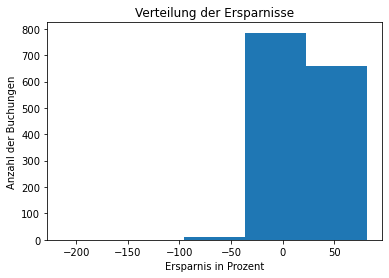

In [86]:
#Zählervariablen
gespart = 0
draufgezahlt = 0
gleich = 0
differenzen = []

#Simuliere 50 mal jeweils 100 Buchungen
for i in range(50):
    gespart, draufgezahlt, gleich, differenz = simuliere_klassifikationsproblem(
        simu_daten, gespart, draufgezahlt, gleich)
    for d in differenz:
        differenzen.append(d)
#Gebe die Ergebnisse aus
sim_ergebnisse(gespart, draufgezahlt, gleich, differenzen)

Die Ergebnisse sehen sehr erfreulich aus. In 70.9% aller Test-Buchungen hat das System die sofortige Buchung empfohlen. Auf diese Weise wurde kein Geld gespart, aber es wurde bereits ein günstiger Flug gebucht.

Interessanter ist die Erkenntnis, dass 27.1% aller Buchungen durch die Empfehlung des Modells bei der Buchung gespart haben. Die Ersparnis liegt im Durchschnitt bei 23.99%. 

Lediglich in 2% aller Buchungen musste zu einem teureren Preis gebucht werden, der im Schnitt 17.73% teurer war. Allerdings sind dies nur 100 von 5000 Buchungen, weshalb die geringe Anzahl von Fehlentscheidungen in Kauf genommen werden kann.

## 8. Fazit <a class="anchor" id="fazit"></a>

## 8.1. Regressionsproblem <a class="anchor" id="fazit2"></a>

Das Ergebnis des besten Modells ist nicht zufriedenstellend. Ein Einsparpotenzial ist nicht gegeben, da in vielen Fällen auch mehr gezahlt werden musste, als wenn man sofort gebucht hätte. In der Praxis könnte dieses Modell daher nicht angewendet werden. 

Machine Learning eignet sich demnach - **zumindest bezogen auf den vorhandenen Datensatz** - nicht, um Flugpreise exakt vorherzusagen, da die Abweichungen zu hoch sind. Dies kann damit begründet werden, dass die jeweilige Preisgestaltung der Airlines zu komplex und unterschiedlich ist, sodass keine Muster in den tatsächlichen Preisen gefunden werden können. Es kann auch sein, dass Airlines ihre Preisgestaltungsstrategien regelmäßig ändern, um eben solche Muster nicht entdecken zu können.

## 8.2. Klassifikationsproblem <a class="anchor" id="fazit3"></a>

Die Ergebnisse der Klassifikation sind zufriedenstellend und bieten ein Einsparpotenzial, da Genauigkeiten von ca. 91% erzielt werden konnten. Bei der Simulation von Flugbuchungen konnte bei mehr als einem Viertel der Buchungen Geld gespart werden, indem auf die Empfehlung des Modells geachtet wurde. 

Demnach eignet sich Machine Learning sehr wohl, um Kunden eine Buchungsempfehlung auszusprechen. Angewendet auf einen deutlich größeren Datensatz mit diversen Airlines und Flughäfen könnten die Ergebnisse der Klassifikation weiter verbessert werden, um noch höhere Einsparungen ermöglichen zu können.